In [1]:
import os
import io
import sys
import json
import boto3
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from collections import Counter

sys.path.append("../")
import cabutils

In [2]:
sns.set_style("darkgrid")
sns.set_context("talk")

from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [3]:
projName = "mlve"
experiment = "nsd"
experimentName = f"{experiment}-surface-normals"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attentionCheck"
batch_idx = "batchIdx"

In [4]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]

Checking database connection...
Connection established!


In [5]:
names = list(db.list_collection_names())
names.sort()

In [6]:
names

['gestalt_object-loc',
 'gestalt_shapegen-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-split-half',
 'gestalt_shapegen-segmentation-split-half',
 'gestalt_shapegen-surface-normals',
 'gestalt_shapegen-surface-normals-split-half',
 'gestalt_shapegen_object-loc',
 'gestalt_shapegen_video-object-loc',
 'gestalt_video-object-loc',
 'hypersim_surface-normals',
 'hypersim_surface-normals-splithalf',
 'hypersim_v2-depth-estimation-pilot',
 'hypersim_v3-depth-estimation-split-half',
 'hypersim_v3-segmentation-split-half',
 'hypersim_v3-surface-normals',
 'nsd-depth-estimation-pilot',
 'nsd-object-loc-split-half',
 'nsd-segmentation',
 'nsd-surface-normals',
 'nsd_surface-normals',
 'tdw-depth-estimation-pilot',
 'tdw-depth-estimation-split-half',
 'tdw-segmentation',
 'tdw-segmentation-split-half',
 'tdw-surface-normals-split-half',
 'tdw_surface-normals']

In [8]:
summaries = {}

In [9]:
def results_to_df(iterName=None):
        results = []
        cursor = col.find({})
        for document in tqdm(cursor):
            results.append(document)

        df = pd.DataFrame(results)
        return df

In [10]:
from glob import glob
names = glob("datasets/*")
names = [name.split(".")[0].split("datasets/")[1] for name in names]

In [11]:
names

['hypersim_surface-normals',
 'gestalt_shapegen-surface-normals',
 'gestalt_shapegen_object-loc',
 'tdw-depth-estimation-pilot',
 'tdw_surface-normals',
 'static_detection_pilot_v1-results',
 'gestalt_object-loc',
 'nsd_surface-normals',
 'hypersim_v3-surface-normals',
 'hypersim_v2-depth-estimation-pilot',
 'tdw-segmentation-split-half',
 'tdw-surface-normals-split-half',
 'gestalt_shapegen_video-object-loc',
 'gestalt_shapegen-segmentation-split-half',
 'tdw-depth-estimation-split-half',
 'nsd-surface-normals',
 'tdw-segmentation',
 'nsd-segmentation',
 'tom_m2s_shapenet13',
 'hypersim_surface-normals-splithalf',
 'tom_m2s_shapenet13',
 'tom_m2s_shapenet13',
 'nsd-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-pilot',
 'tom_m2s_shapenet13',
 'hypersim_v3-depth-estimation-split-half',
 'nsd-object-loc-split-half',
 'gestalt_shapegen-surface-normals-split-half',
 'hypersim_v3-segmentation-split-half',
 'gestalt_video-object-loc',
 'gestalt_shapegen-depth-estimation-split-

In [12]:
db = None

In [14]:
for col_name in tqdm(names):
    if "depth" not in col_name and "surface" not in col_name and "segmentation" not in col_name:
        continue
    summaries[col_name] = {}
    print("Getting summary data for ", col_name)
    
    if os.path.exists(f"datasets/{col_name}.csv"):
        df = pd.read_csv(f"datasets/{col_name}.csv")
    else:
        col = db[col_name]
        df = results_to_df() # drop non-experiment trials
        df.to_csv(f"datasets/{col_name}.csv")
    
    get_trial_key = lambda x: [key for key in x if "batch" in key][0]
    
    total_records = len(df)
    n_participants = len(df["userID"].dropna().unique())
    iteration_names = df["iterationName"].unique()

    get_batch_key = lambda x: [key for key in x if "batch" in key][0]
    batch_key = get_batch_key(df.columns)
    n_batches = len(df[batch_key].dropna().unique())
    
    print(f"Total Records: {total_records}, n_participants: {n_participants}, n_points: {n_batches}, iterations: {len(iteration_names)}")
    
    summaries[col_name]["n_participants"] = n_participants
    summaries[col_name]["n_points"] = n_batches
    summaries[col_name]["total_records"] = total_records
    summaries[col_name]["n_iterations"] = len(iteration_names)
    summaries[col_name]["iteration_names"] = iteration_names
    

  0%|                                                                                                                                                                              | 0/31 [00:00<?, ?it/s]

Getting summary data for  hypersim_surface-normals


  3%|█████▎                                                                                                                                                                | 1/31 [00:00<00:21,  1.43it/s]

Total Records: 7647, n_participants: 58, n_points: 10, iterations: 2
Getting summary data for  gestalt_shapegen-surface-normals


  6%|██████████▋                                                                                                                                                           | 2/31 [00:01<00:28,  1.00it/s]

Total Records: 13827, n_participants: 105, n_points: 11, iterations: 1
Getting summary data for  tdw-depth-estimation-pilot
Total Records: 4105, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  tdw_surface-normals


 16%|██████████████████████████▊                                                                                                                                           | 5/31 [00:02<00:11,  2.22it/s]

Total Records: 6409, n_participants: 52, n_points: 10, iterations: 2
Getting summary data for  nsd_surface-normals


 26%|██████████████████████████████████████████▊                                                                                                                           | 8/31 [00:02<00:06,  3.63it/s]

Total Records: 4109, n_participants: 32, n_points: 10, iterations: 1
Getting summary data for  hypersim_v3-surface-normals


 29%|████████████████████████████████████████████████▏                                                                                                                     | 9/31 [00:04<00:09,  2.24it/s]

Total Records: 13327, n_participants: 104, n_points: 11, iterations: 1
Getting summary data for  hypersim_v2-depth-estimation-pilot
Total Records: 4039, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  tdw-segmentation-split-half
Total Records: 4110, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  tdw-surface-normals-split-half


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 12/31 [00:04<00:05,  3.28it/s]

Total Records: 4250, n_participants: 33, n_points: 1, iterations: 1
Getting summary data for  gestalt_shapegen-segmentation-split-half
Total Records: 4192, n_participants: 31, n_points: 1, iterations: 1
Getting summary data for  tdw-depth-estimation-split-half
Total Records: 4098, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  nsd-surface-normals


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 18/31 [00:06<00:03,  3.29it/s]

Total Records: 21948, n_participants: 213, n_points: 31, iterations: 2
Getting summary data for  tdw-segmentation
Total Records: 3014, n_participants: 22, n_points: 1, iterations: 1
Getting summary data for  nsd-segmentation
Total Records: 32160, n_participants: 252, n_points: 30, iterations: 1
Getting summary data for  hypersim_surface-normals-splithalf


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 20/31 [00:06<00:03,  3.62it/s]

Total Records: 5041, n_participants: 40, n_points: 1, iterations: 1
Getting summary data for  nsd-depth-estimation-pilot
Total Records: 4110, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  gestalt_shapegen-depth-estimation-pilot
Total Records: 5098, n_participants: 39, n_points: 10, iterations: 1
Getting summary data for  hypersim_v3-depth-estimation-split-half
Total Records: 4110, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  gestalt_shapegen-surface-normals-split-half


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.20it/s]

Total Records: 4070, n_participants: 35, n_points: 1, iterations: 1
Getting summary data for  hypersim_v3-segmentation-split-half
Total Records: 4216, n_participants: 31, n_points: 1, iterations: 1
Getting summary data for  gestalt_shapegen-depth-estimation-split-half
Total Records: 4115, n_participants: 31, n_points: 1, iterations: 1


In [15]:
all_summaries = summaries

summaries = {}
for key in all_summaries:
    if "object-loc" not in key:
        summaries[key] = all_summaries[key]

In [16]:
summary_df = pd.DataFrame(summaries)

In [17]:
summary_df

,hypersim_surface-normals,gestalt_shapegen-surface-normals,tdw-depth-estimation-pilot,tdw_surface-normals,static_detection_pilot_v1-results,nsd_surface-normals,hypersim_v3-surface-normals,hypersim_v2-depth-estimation-pilot,tdw-segmentation-split-half,tdw-surface-normals-split-half,...,nsd-surface-normals,tdw-segmentation,nsd-segmentation,hypersim_surface-normals-splithalf,nsd-depth-estimation-pilot,gestalt_shapegen-depth-estimation-pilot,hypersim_v3-depth-estimation-split-half,gestalt_shapegen-surface-normals-split-half,hypersim_v3-segmentation-split-half,gestalt_shapegen-depth-estimation-split-half
n_participants,58,105,30,52,NaN,32,104,30,30,33,...,213,22,252,40,30,39,30,35,31,31
n_points,10,11,10,10,NaN,10,11,10,1,1,...,31,1,30,1,10,10,1,1,1,1
total_records,7647,13827,4105,6409,NaN,4109,13327,4039,4110,4250,...,21948,3014,32160,5041,4110,5098,4110,4070,4216,4115
n_iterations,2,1,1,2,NaN,1,1,1,1,1,...,2,1,1,1,1,1,1,1,1,1
iteration_names,"[v2, 071822_absolute]",[large-scale-v1],[v1-full],"[v2, 071822_absolute]",NaN,[v2],[large-scale-v1],[v1-full],[v1-full],[v1-full],...,"[large-scale-v1, v2-all]",[large-scale-v1],[v2-all],[080822-relative],[v1-full],[v1-full],[v1-full],[v1-full],[v1-full],[v1-full]


In [18]:
stat_first = {"n_participants": {}, "n_points": {}, "n_iterations": {}, "total_records": {}, "iteration_names": {}}
for dataset in summaries:
    for stat in summaries[dataset]:
        stat_first[stat][dataset] = summaries[dataset][stat]

In [19]:
stat_df = pd.DataFrame(stat_first)

In [20]:
stat_df.to_csv("stat_df.csv")

In [21]:
stat_df

,n_participants,n_points,n_iterations,total_records,iteration_names
hypersim_surface-normals,58,10,2,7647,"[v2, 071822_absolute]"
gestalt_shapegen-surface-normals,105,11,1,13827,[large-scale-v1]
tdw-depth-estimation-pilot,30,10,1,4105,[v1-full]
tdw_surface-normals,52,10,2,6409,"[v2, 071822_absolute]"
nsd_surface-normals,32,10,1,4109,[v2]
hypersim_v3-surface-normals,104,11,1,13327,[large-scale-v1]
hypersim_v2-depth-estimation-pilot,30,10,1,4039,[v1-full]
tdw-segmentation-split-half,30,1,1,4110,[v1-full]
tdw-surface-normals-split-half,33,1,1,4250,[v1-full]
gestalt_shapegen-segmentation-split-half,31,1,1,4192,[v1-full]


In [22]:
stat_df["n_participants"].sum()

1258

In [23]:
import plotting
%load_ext autoreload
%autoreload 2

In [24]:
def filter_attention_check_fails(df, key="correct", threshold=0.5, remove_failures=True, remove_attention_trials=True):
    att_key = lambda x: [k for k in x if "attention" in k][0]
    attention_key = att_key(df.columns)
    att_checks = df.loc[df[attention_key] == True]
    failed_checks = att_checks.groupby("userID")[key].mean() < threshold
    participants_failed = [failed_checks.keys()[i] for i in range(len(failed_checks)) if failed_checks[i]]
    if remove_failures:
        if len(participants_failed) == 0:
            print("No one failed any attention checks!")
        else:   
            df = df[~df["userID"].isin(participants_failed)]
        
    if remove_attention_trials:
        df = df[df[attention_key] == False]
            
    return df

def str_to_float_array(str_arr):
    if type(str_arr) == list:
        return str_arr
    
    if str_arr == np.nan or str_arr == "nan" or str_arr == float("nan") or not str_arr:
        return []

    arr = []
    str_arr = str_arr.strip("[]").split(",")
    for st in str_arr:
        try:
            arr.append(float(st))
        except:
            return []
    return arr

tdw-depth-estimation-pilot


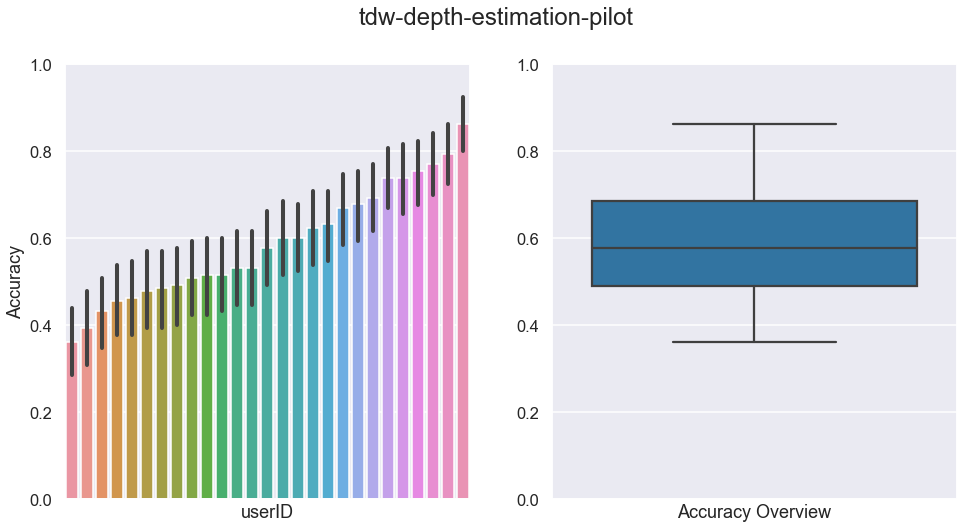

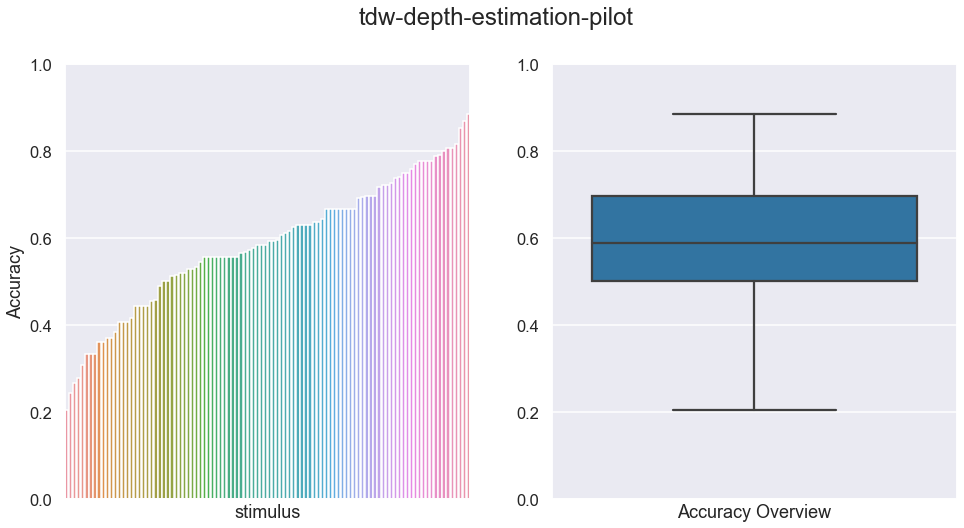

Minimum people per trial: 4
Not enough people to check split half.



hypersim_v2-depth-estimation-pilot


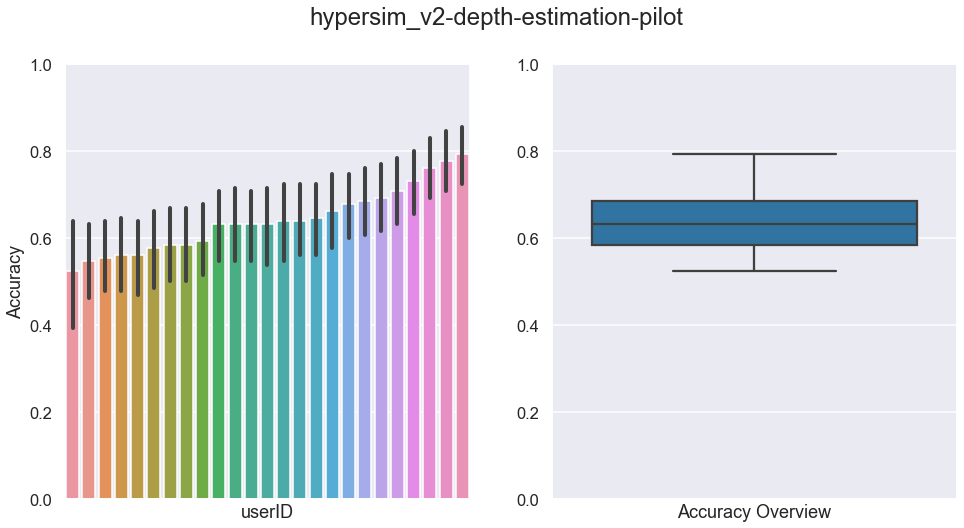

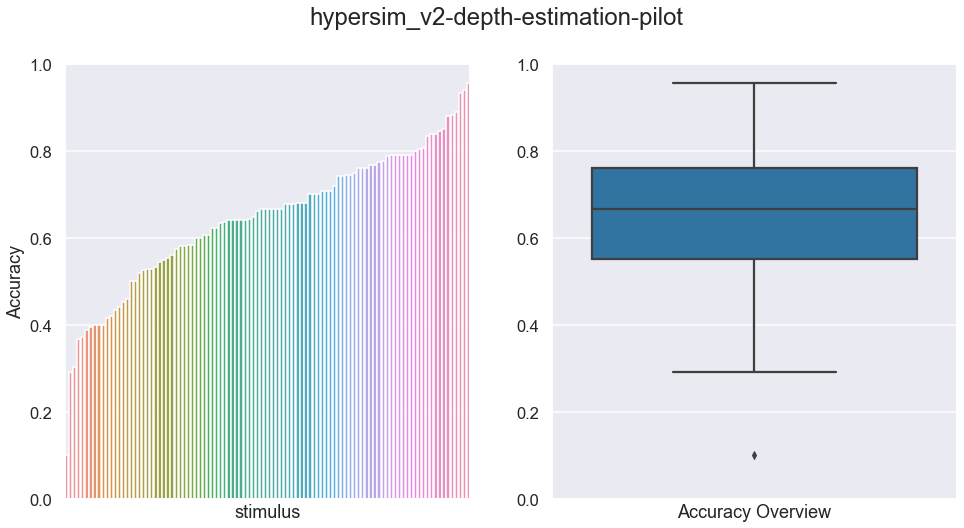

Minimum people per trial: 3
Not enough people to check split half.



tdw-segmentation-split-half
No one failed any attention checks!


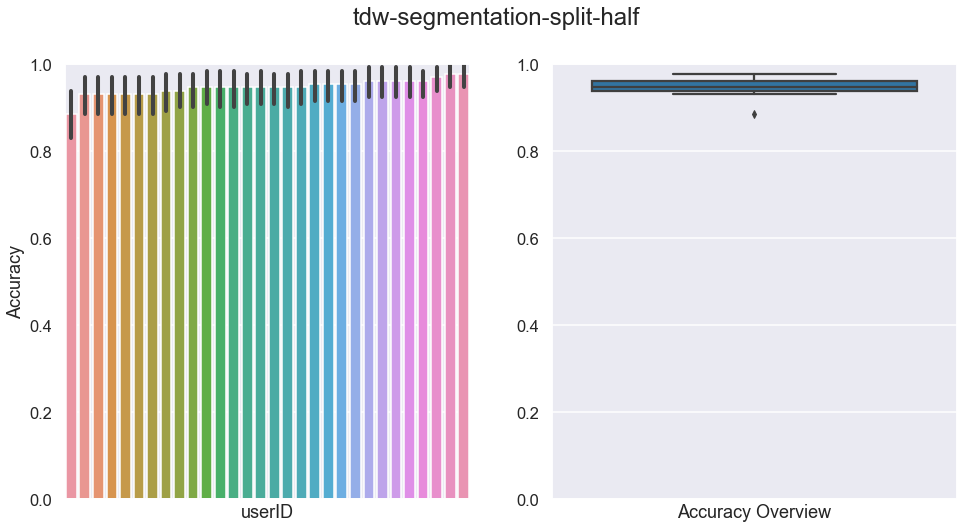

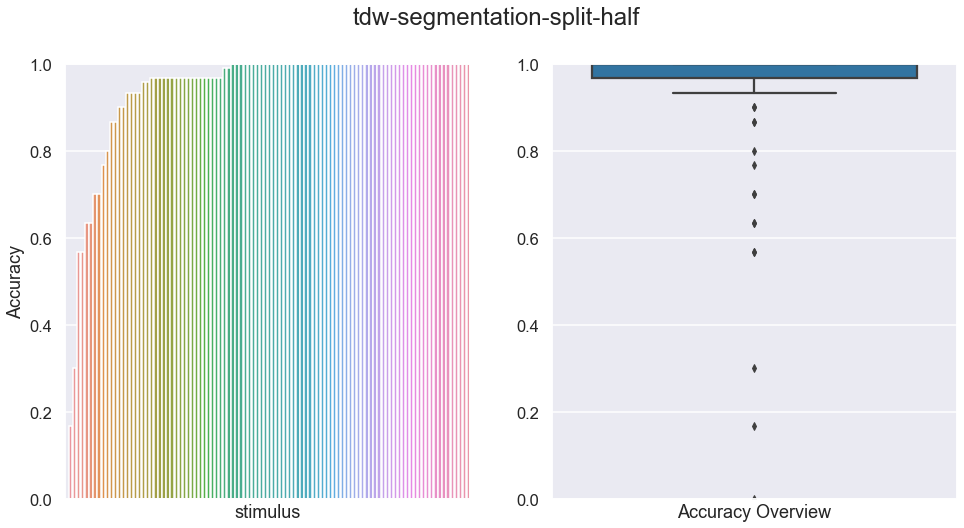

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


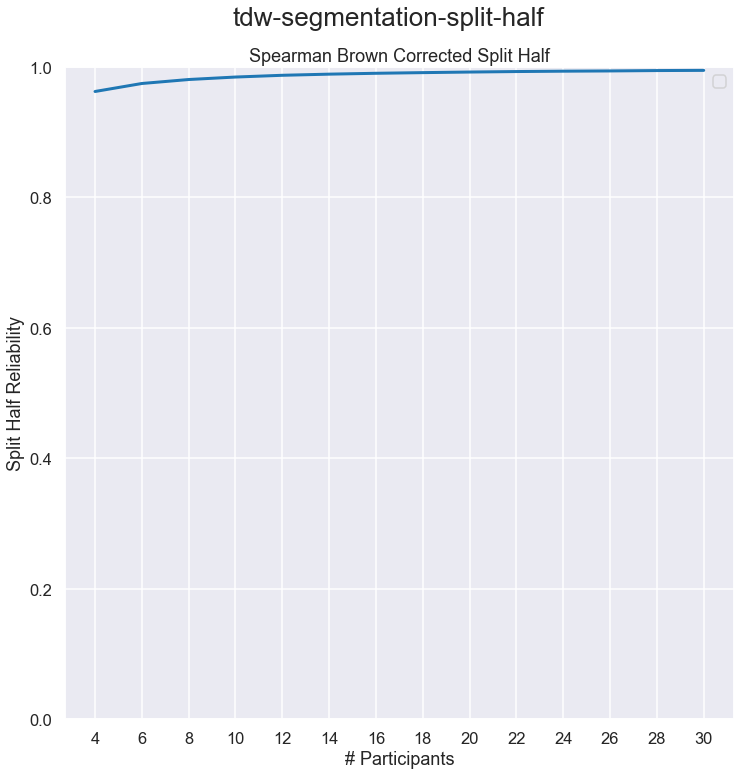




gestalt_shapegen-segmentation-split-half
No one failed any attention checks!


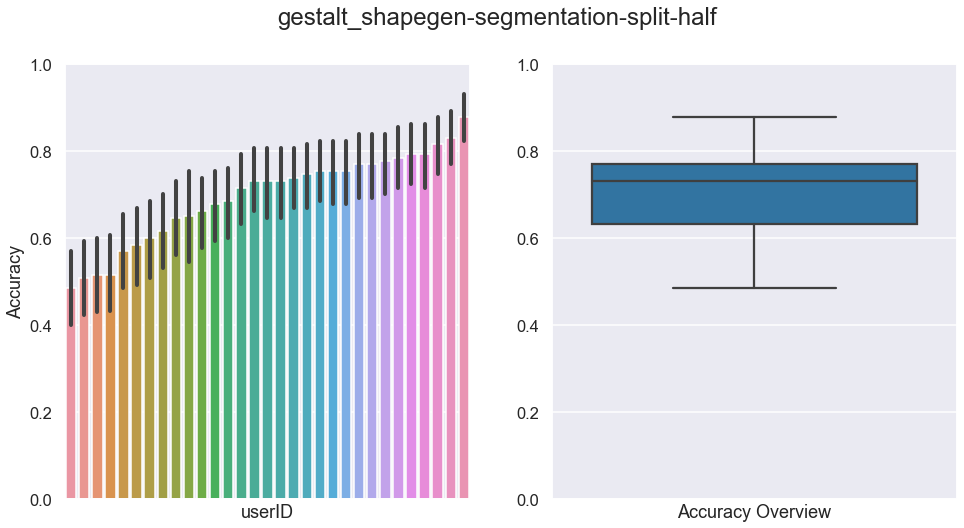

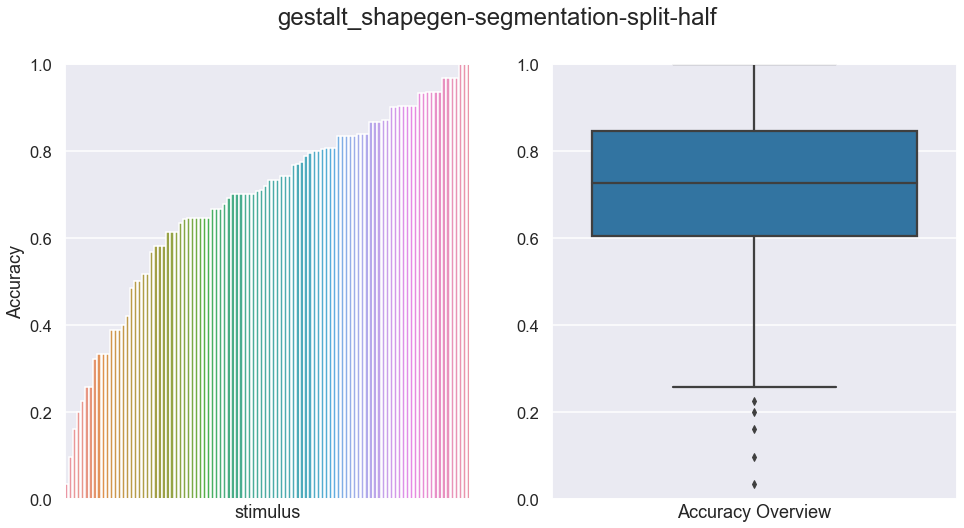

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


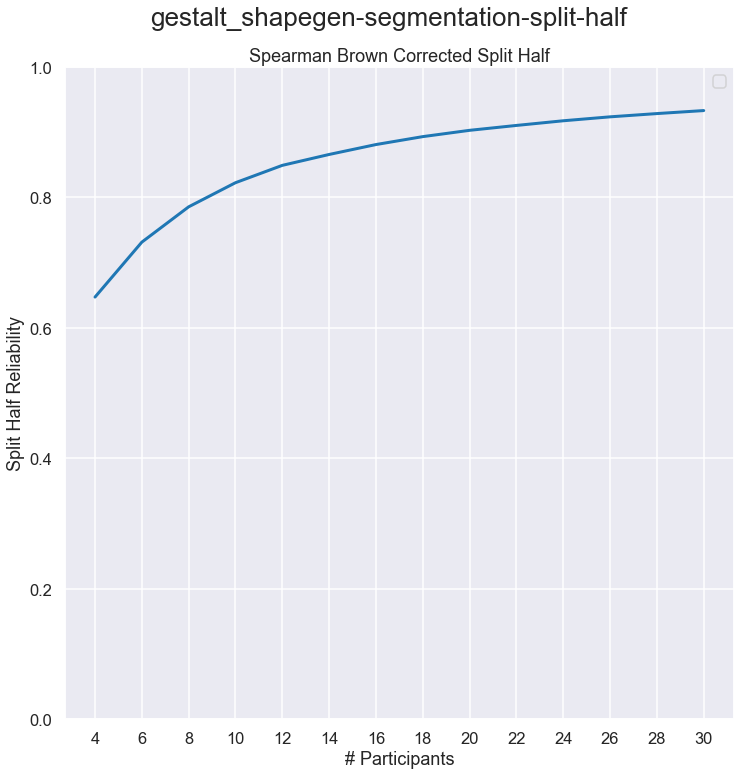




tdw-depth-estimation-split-half


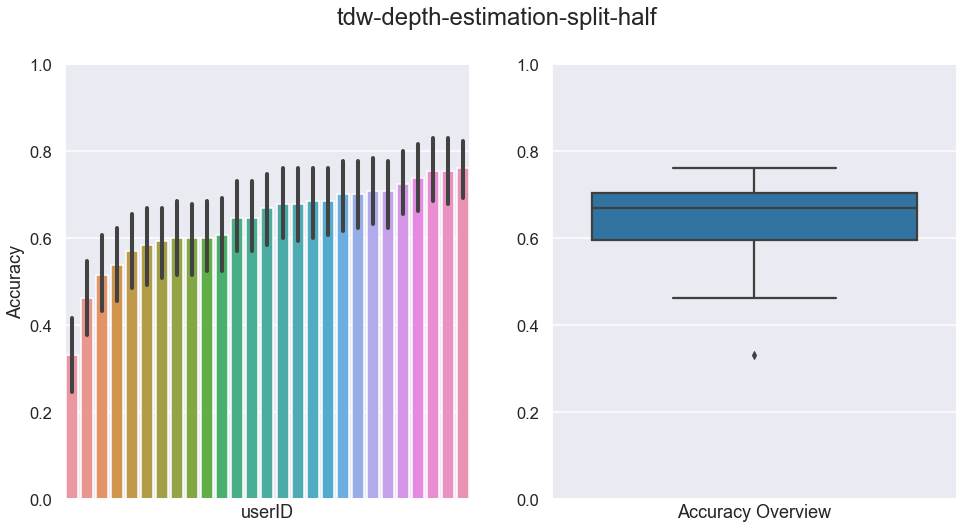

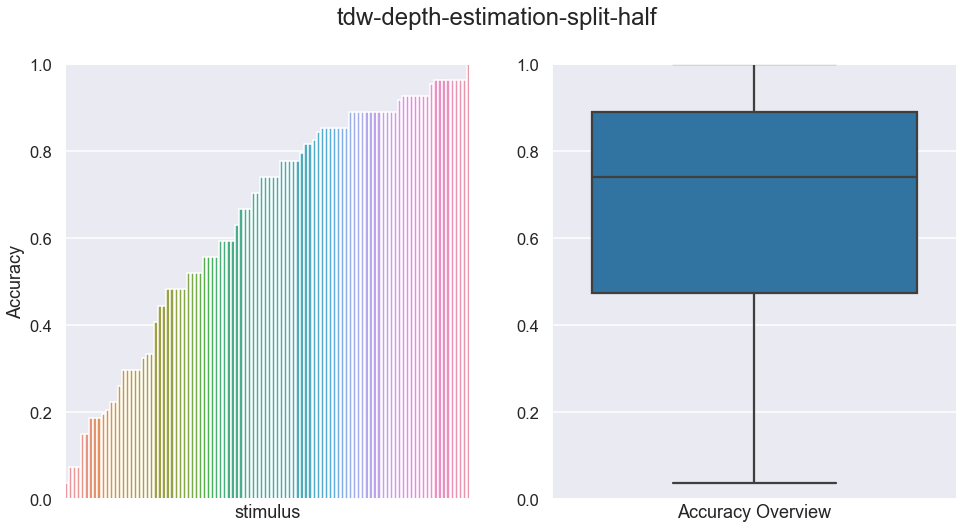

Minimum people per trial: 27
(100, 27) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13]


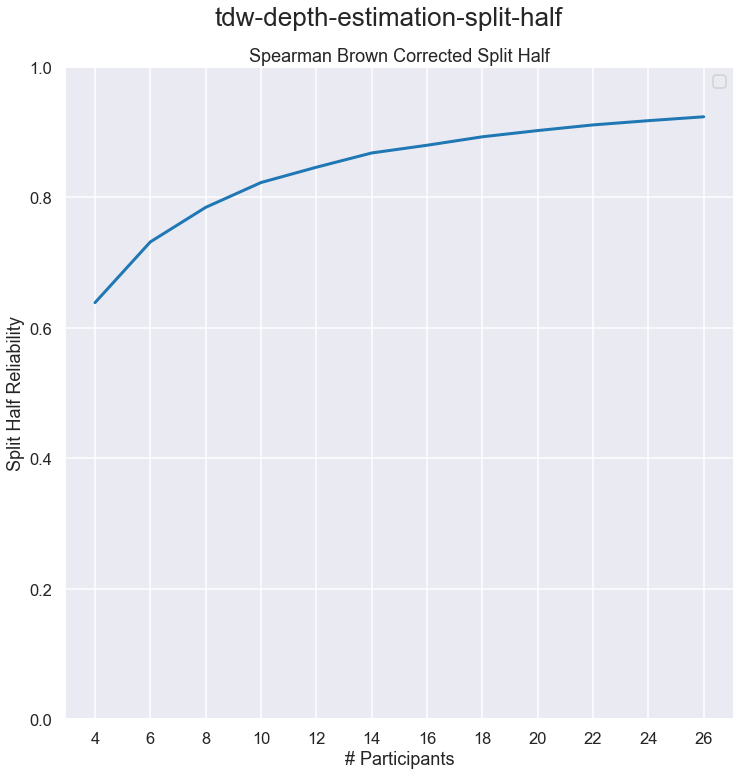




tdw-segmentation


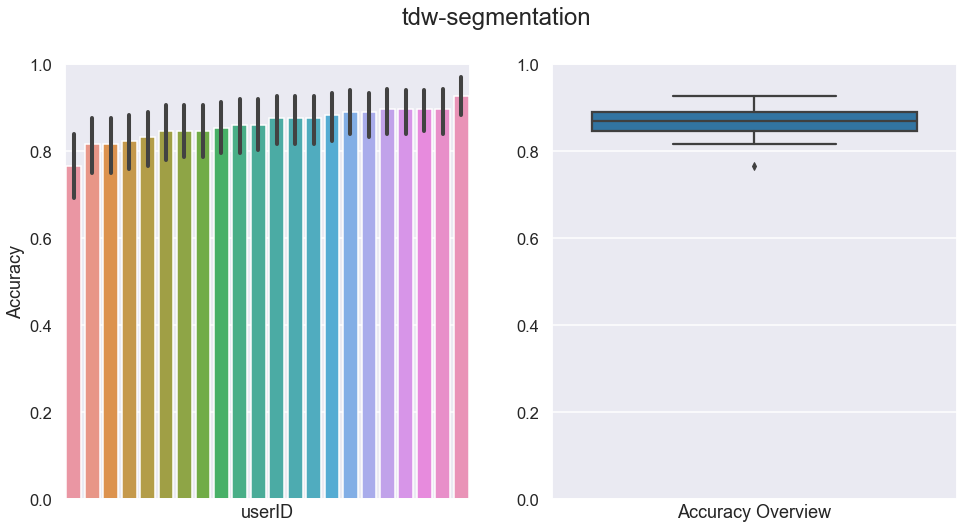

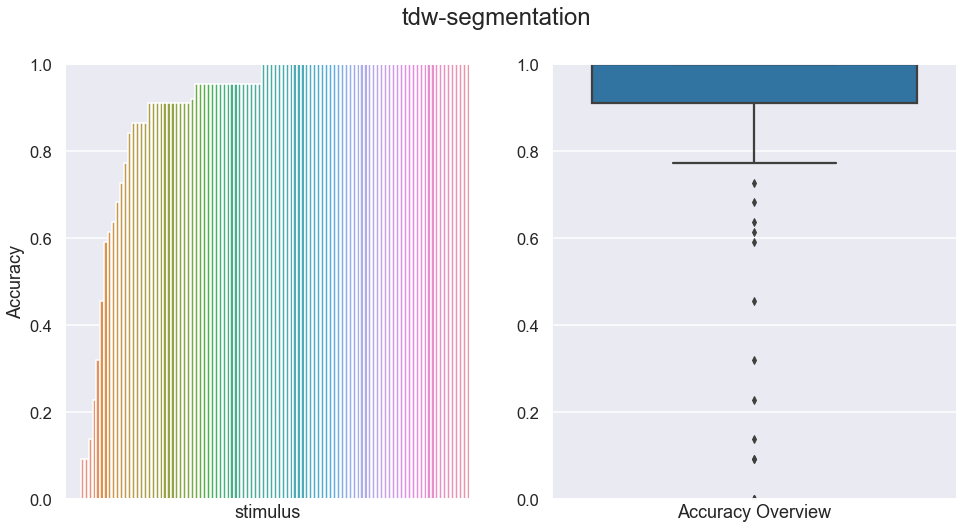

Minimum people per trial: 22
(103, 22) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11]


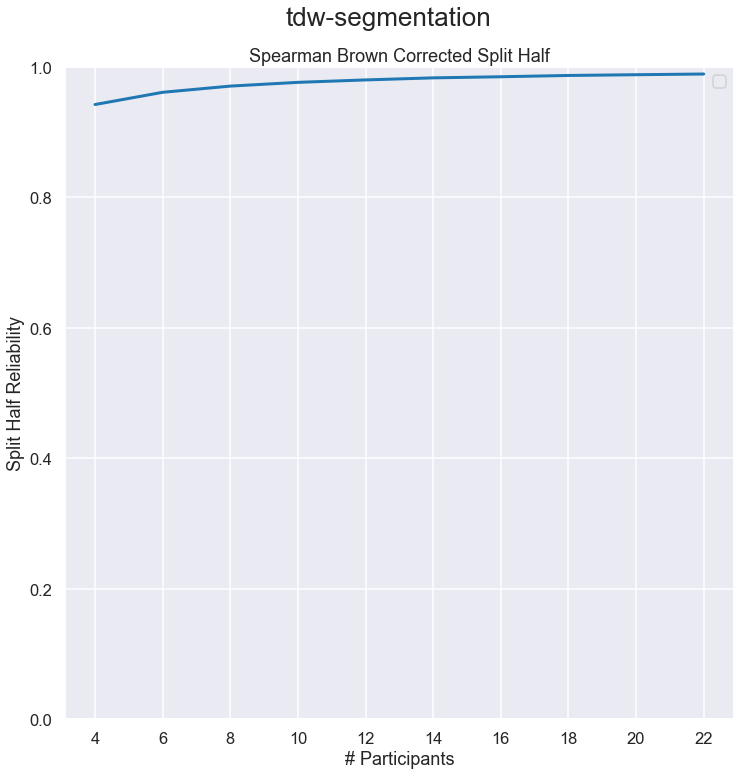




nsd-segmentation


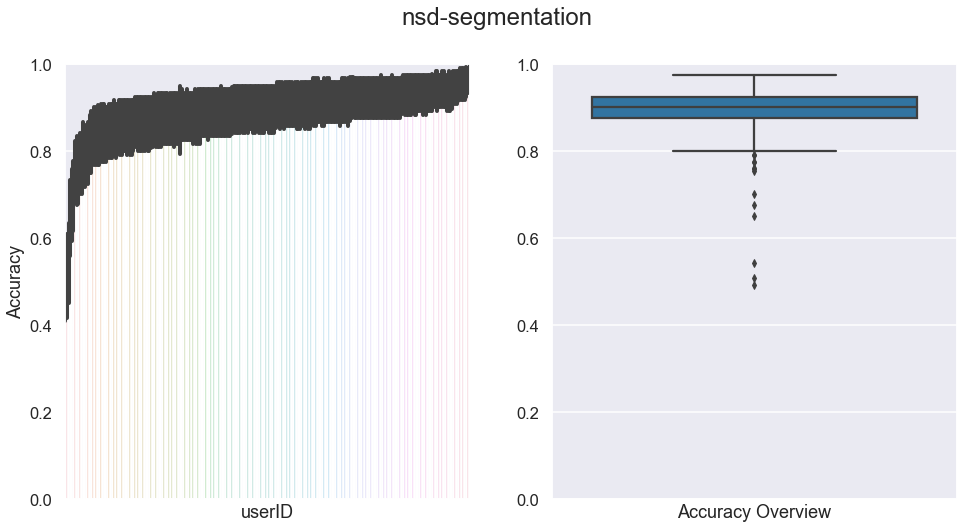

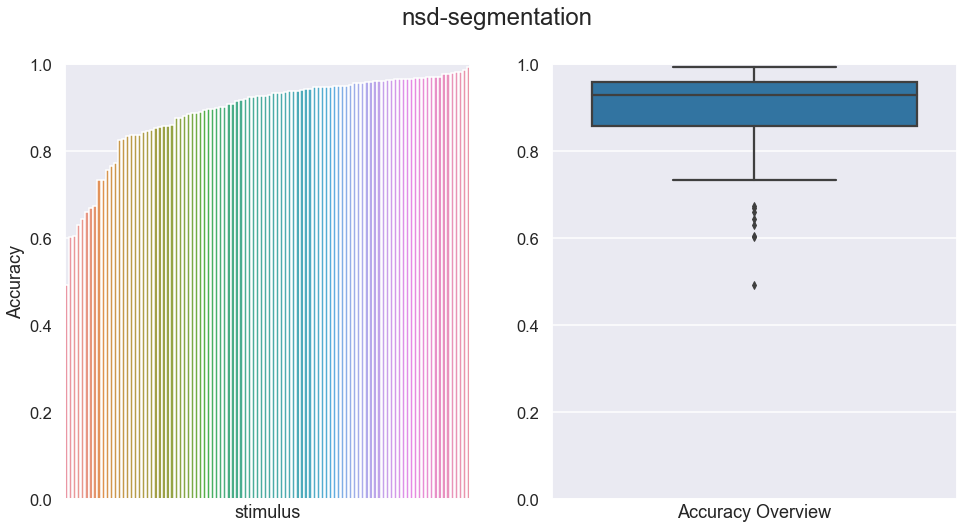

Minimum people per trial: 21
(100, 21) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10]


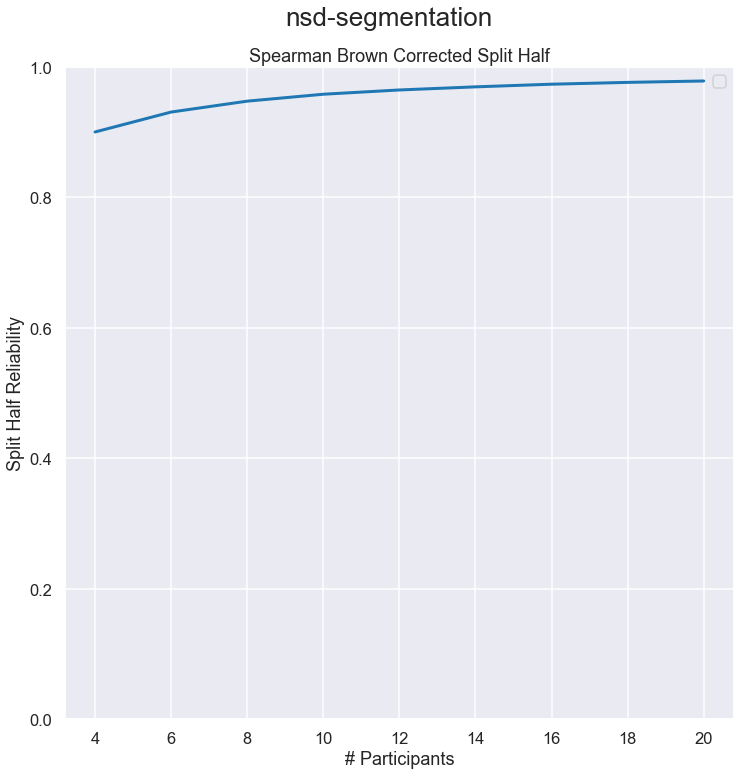




Minimum people per trial: 21
(100, 21) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10]


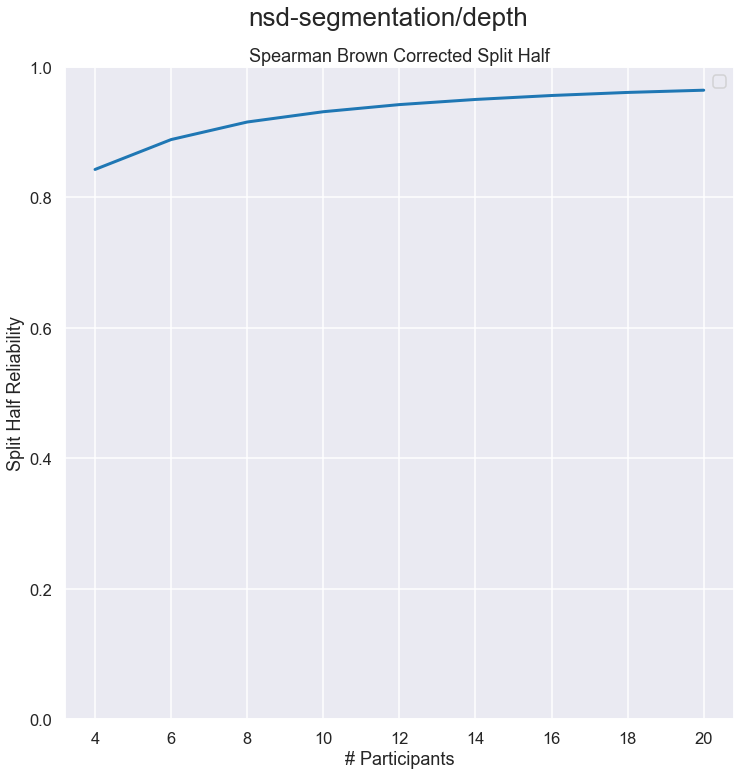

0.9820716975975587
nsd-depth-estimation-pilot
gestalt_shapegen-depth-estimation-pilot


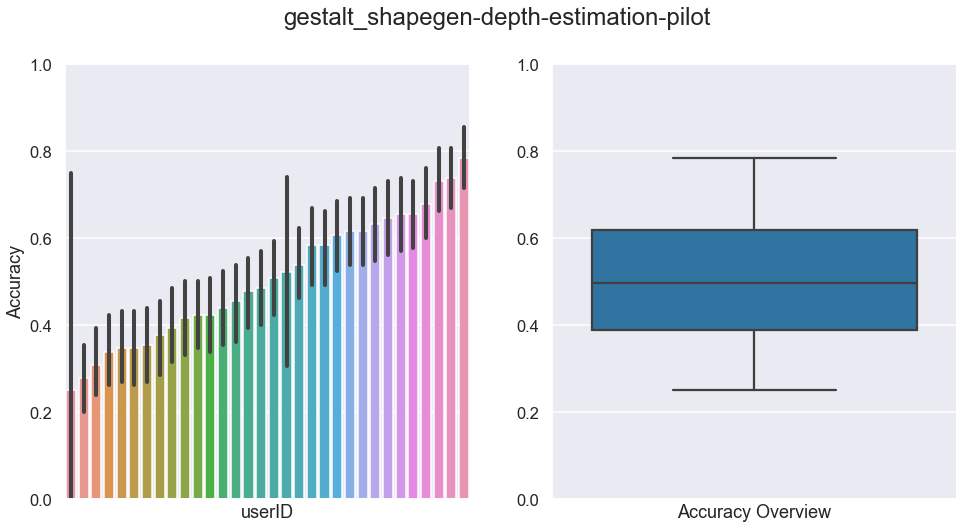

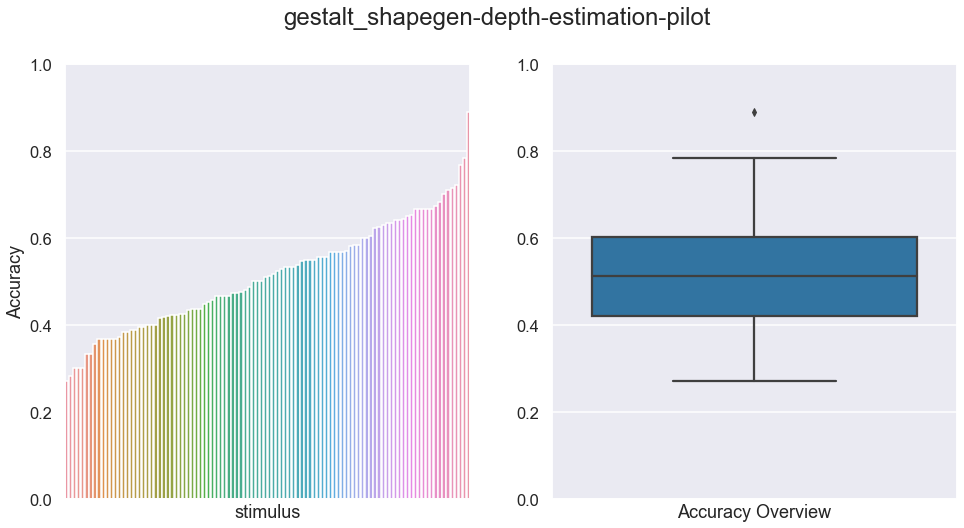

Minimum people per trial: 5
Not enough people to check split half.



hypersim_v3-depth-estimation-split-half
No one failed any attention checks!


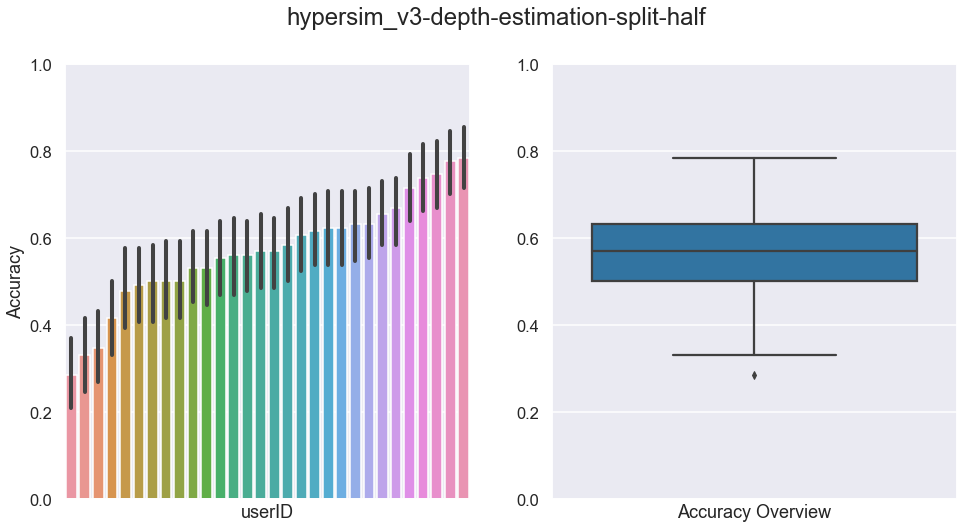

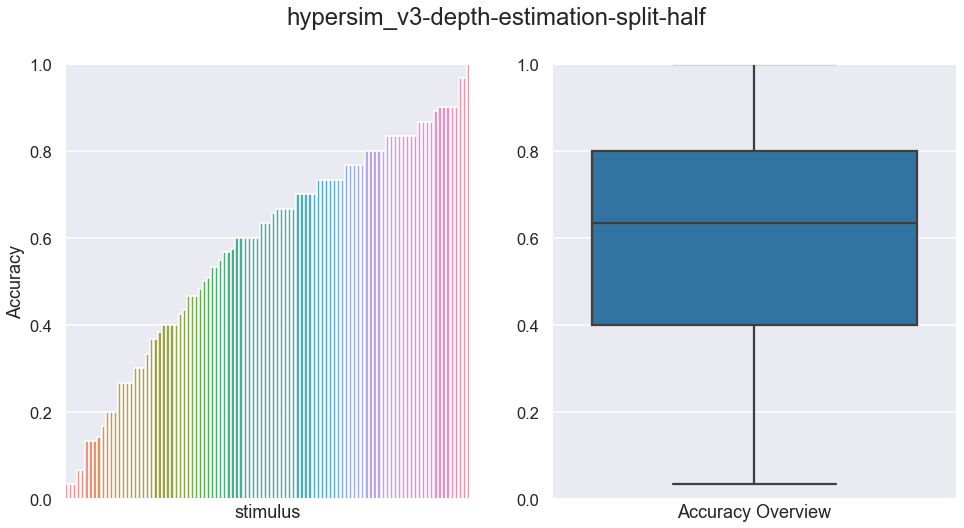

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


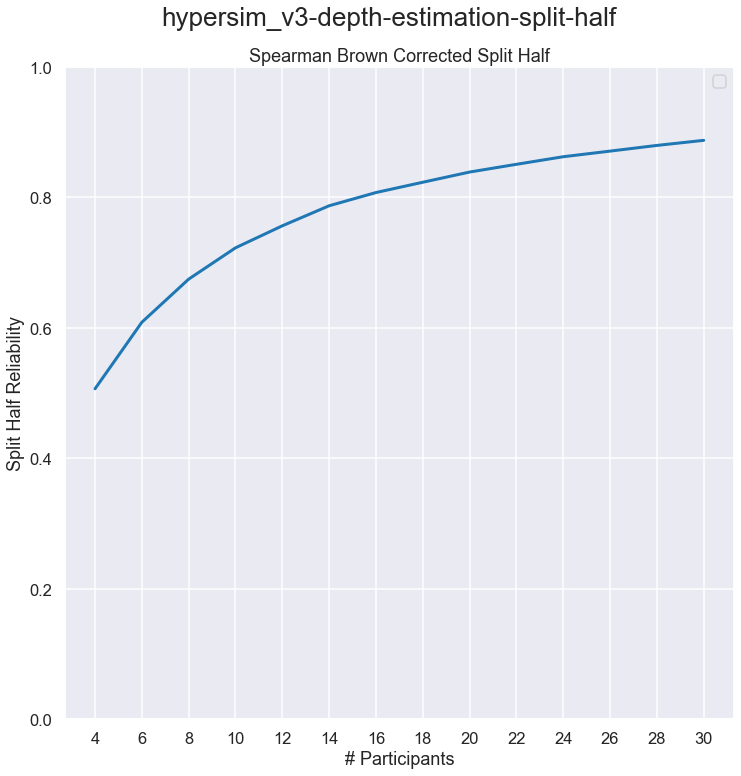




hypersim_v3-segmentation-split-half
No one failed any attention checks!


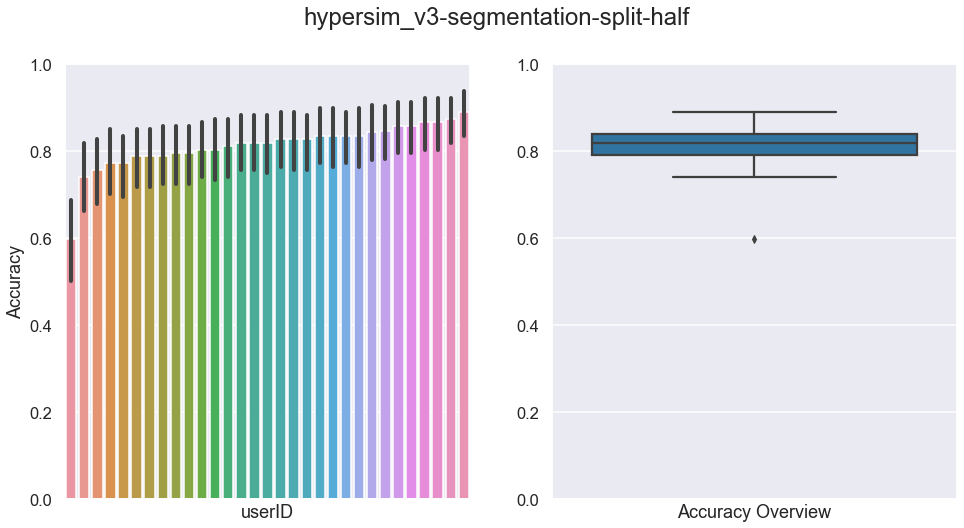

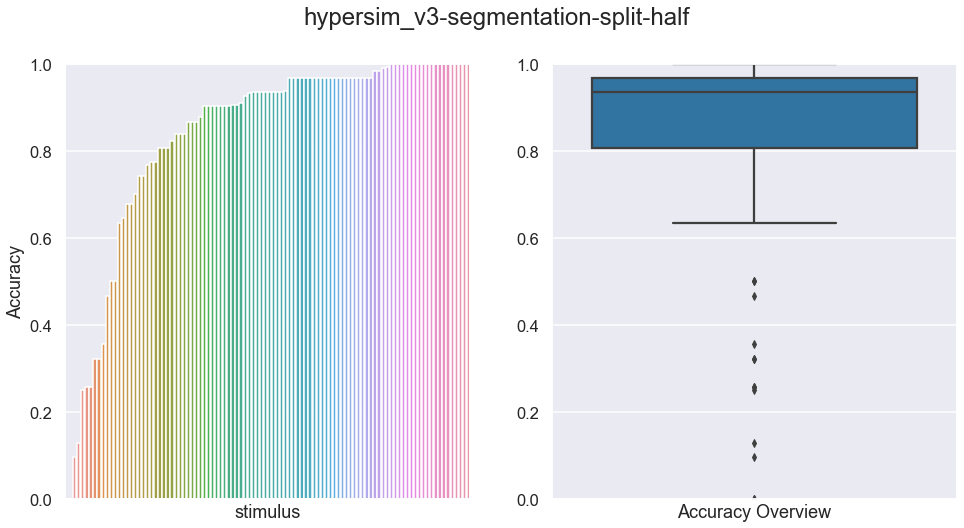

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


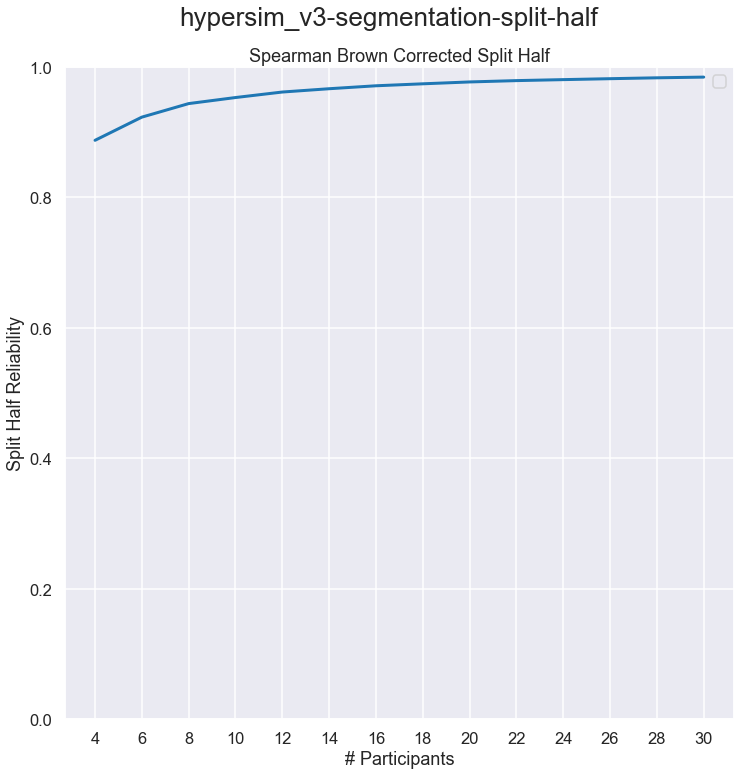




gestalt_shapegen-depth-estimation-split-half


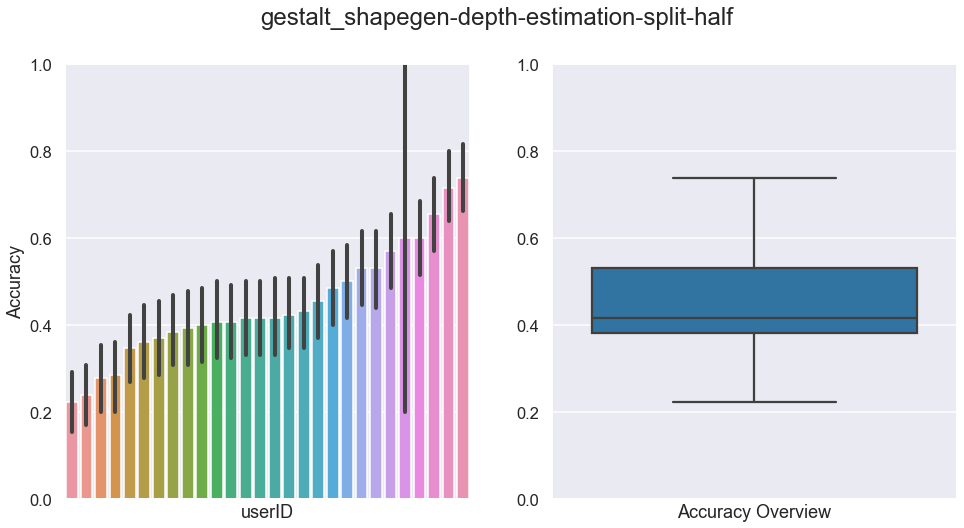

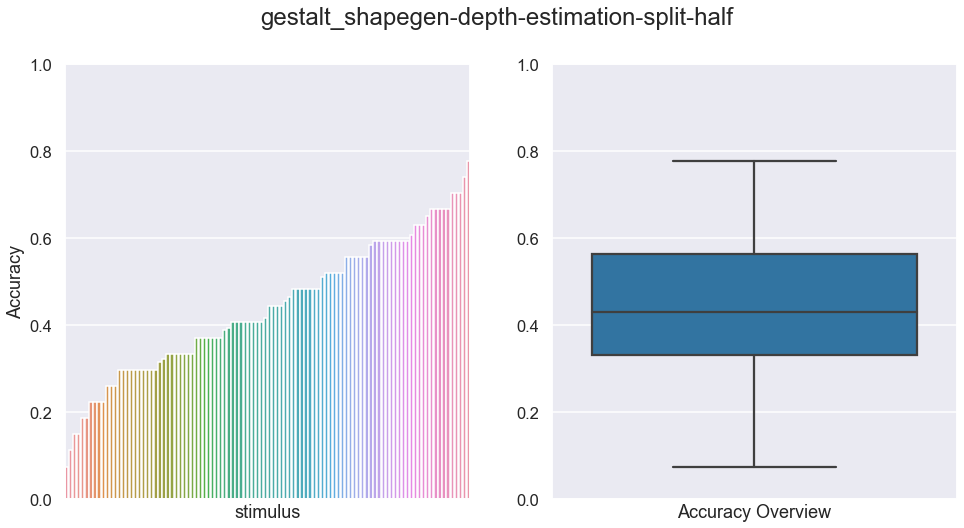

Minimum people per trial: 27
(100, 27) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13]


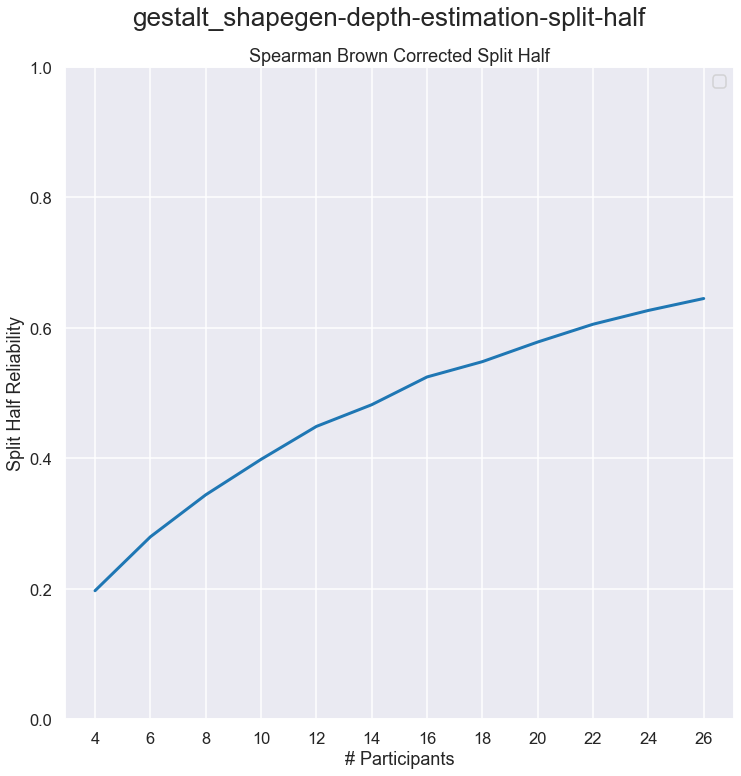

In [105]:
accuracies = {'segmentation': {}, 'depth': {}, 'normals': {}}
dsets = {'segmentation': [], 'depth': [], 'normals': []}
split_halfs = {'segmentation': {}, 'depth': {}, 'normals': {}}
nsd_joint_depth_split_half = 0

for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "depth" in path or "segmentation" in path:
        
        if 'depth' in path:
            key = 'depth'
        elif 'segmentation' in path:
            key = 'segmentation'
        
        print(col_name)

        if col_name == "nsd-depth-estimation-pilot" or col_name == "nsd-depth-estimation-split-half":
            continue
            
        accuracy_key = "correct"
        target_key = "userID"
        
        if col_name == "nsd-segmentation" or col_name == "tdw-segmentation":
            accuracy_key = "segmentation_correct"
            
        
        df = pd.read_csv(path)
        if col_name != "tdw-segmentation":   # the TDW segmentation/depth task had a bug with attention checks
            df = filter_attention_check_fails(df, accuracy_key)
            
        df = df[df["trial_type"].str.contains("task")]
        
        fig, mean_acc = plotting.plot_accuracy(df, col_name, accuracy_key=accuracy_key, target_key=target_key)
        plt.show()
        plt.close()
        fig = plotting.plot_accuracy(df, col_name, accuracy_key=accuracy_key, errorbar=None, target_key="stimulus")
        plt.show()
        plt.close()
        
        if df["response"].iloc[0] is np.nan:
            response_key = "segmentation_response"
        else:
            response_key = "response"
            
        df[response_key] = pd.to_numeric(df[response_key])
        
        split_half = plotting.plot_split_half(df, response_key, col_name)
        print("\n\n")
        
        if col_name == "nsd-segmentation":
            df["depth_response"] = df["depth_response"].fillna(-1)
            depth_split_half = plotting.plot_split_half(df, "depth_response", col_name + "/depth")
            nsd_joint_depth_split_half = np.max(depth_split_half)
            print(nsd_joint_depth_split_half)
            
        accuracies[key][col_name] = mean_acc
        dsets[key].append(col_name)
        split_halfs[key][col_name] = np.max(split_half)

datasets/hypersim_surface-normals.csv
Minimum people per trial: 8
(100, 8, 3) trials to choose from
Subs per split [2 3 4]


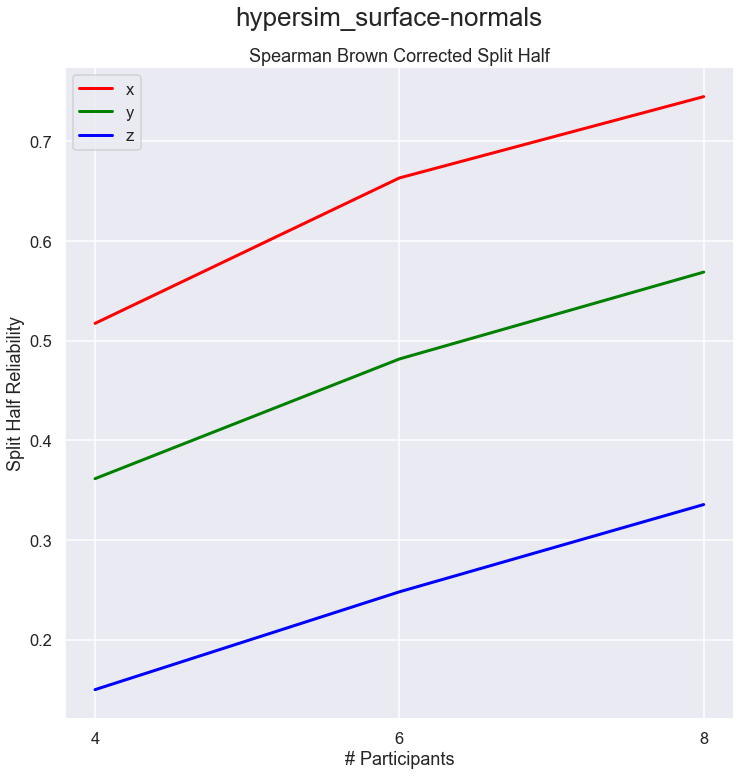

datasets/gestalt_shapegen-surface-normals.csv
Minimum people per trial: 11
(100, 11, 3) trials to choose from
Subs per split [2 3 4 5]


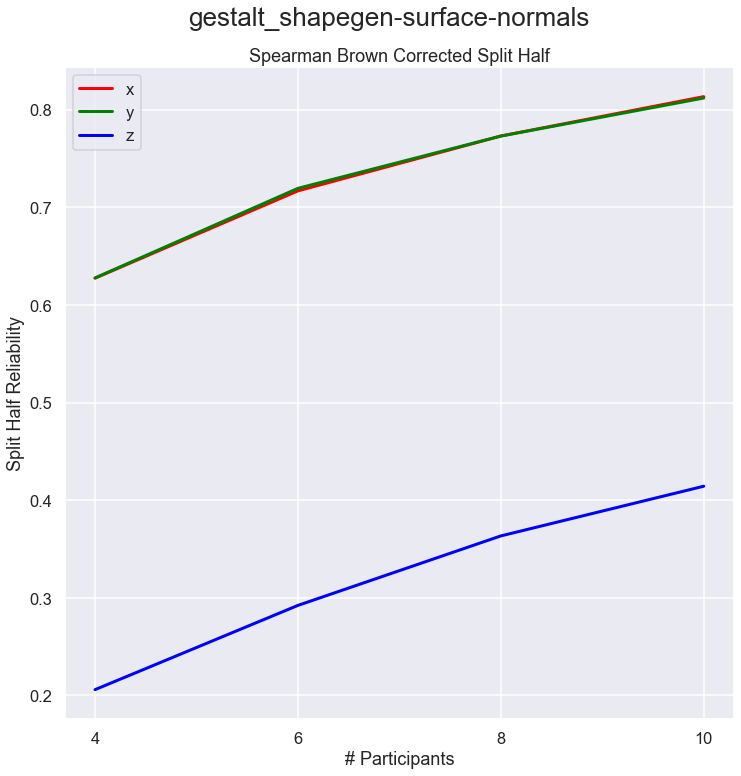

datasets/tdw_surface-normals.csv
Minimum people per trial: 6
Not enough people to check split half.
datasets/nsd_surface-normals.csv
Minimum people per trial: 4
Not enough people to check split half.
datasets/hypersim_v3-surface-normals.csv
Minimum people per trial: 10
(100, 10, 3) trials to choose from
Subs per split [2 3 4 5]


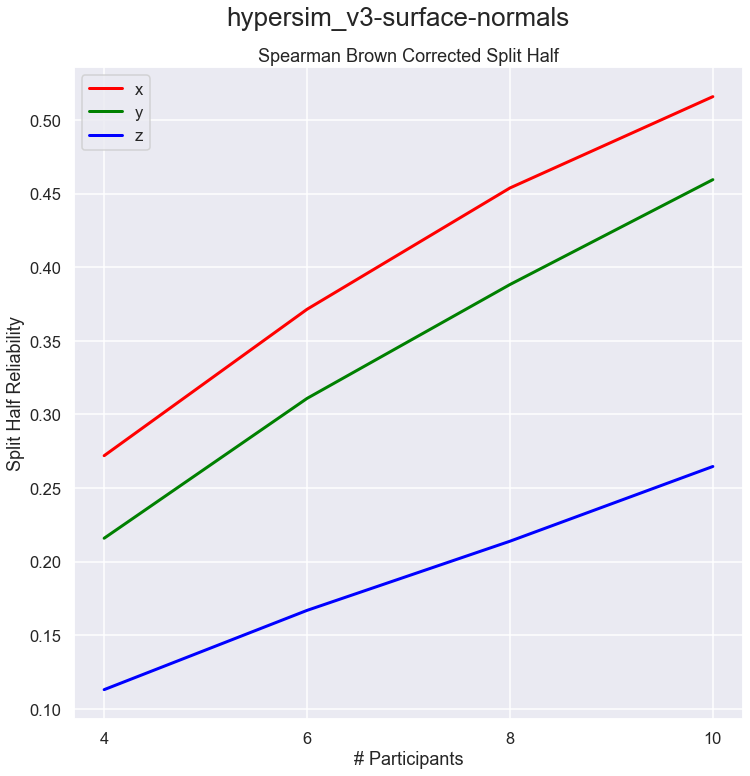

datasets/tdw-surface-normals-split-half.csv
Minimum people per trial: 29
(100, 29, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14]


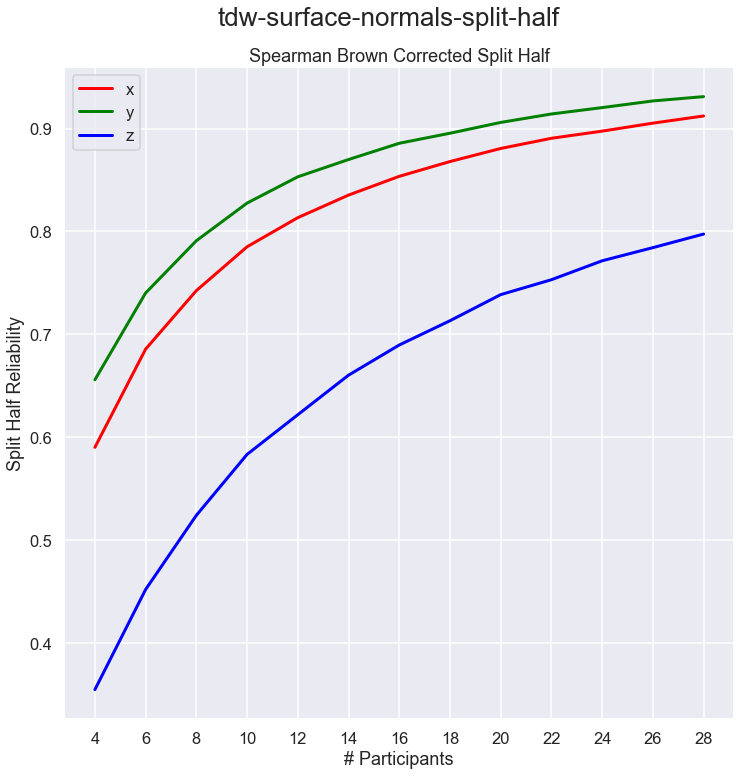

datasets/nsd-surface-normals.csv
Minimum people per trial: 12
(100, 12, 3) trials to choose from
Subs per split [2 3 4 5 6]


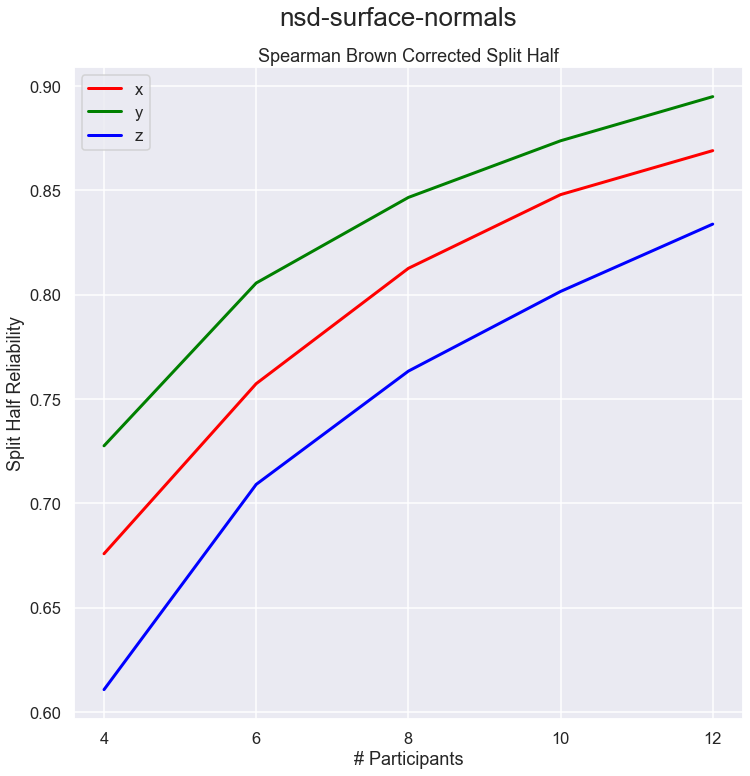

datasets/hypersim_surface-normals-splithalf.csv
Minimum people per trial: 38
(100, 38, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


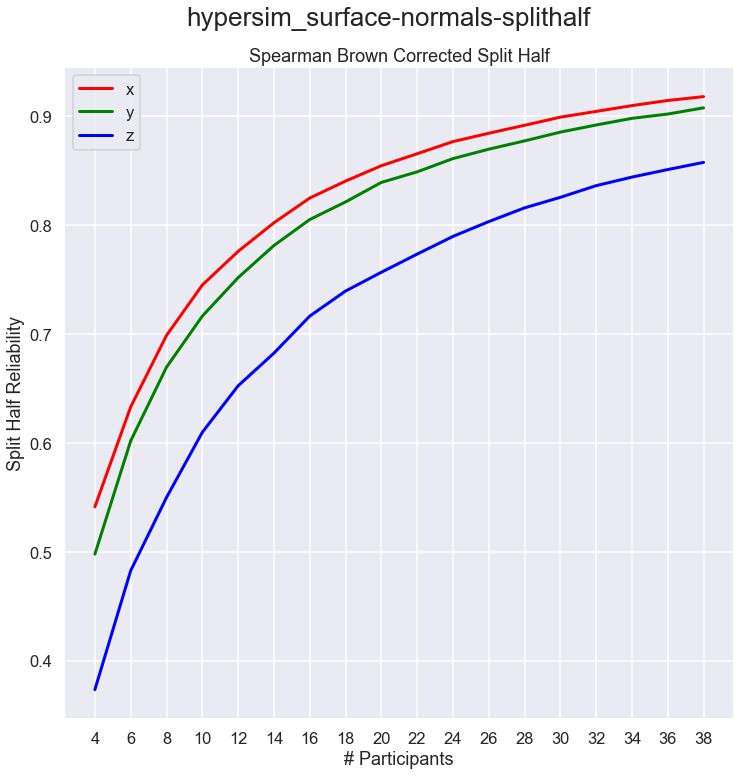

datasets/gestalt_shapegen-surface-normals-split-half.csv
Minimum people per trial: 28
(100, 28, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14]


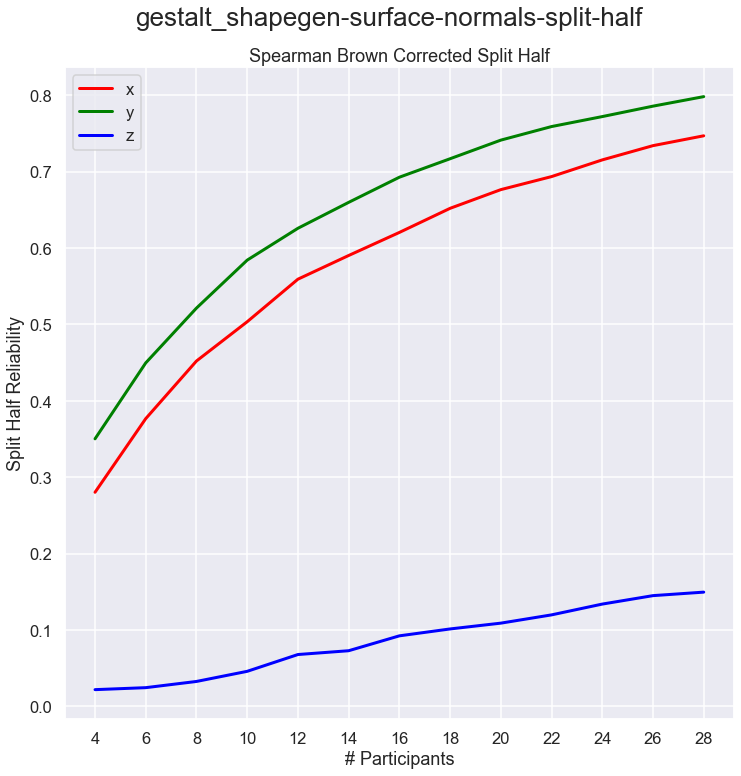

In [106]:
for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "surface-normals" in path:
        # if "hypersim_surface-normals" in path:
        #     continue
        
        print(path)
        
        df = pd.read_csv(path)
        df = df.dropna(axis=0, subset="indicatorFinalDirection")
        get_attention_key = lambda x: [k for k in x if "attention" in k][0]
        attention_key = get_attention_key(df.columns)
        get_duplicate_key = lambda x: [k for k in x if "duplicate" in k][0]
        duplicate_key = get_duplicate_key(df.columns)
        
        df = df[df[duplicate_key] == False]
        df = df[df[attention_key] == False]
        
        df["indicatorFinalDirection"] = df["indicatorFinalDirection"].apply(str_to_float_array)
        if "nsd" not in col_name:
            df["trueArrowDirection"] = df["trueArrowDirection"].apply(str_to_float_array)
            
        split_half, split_half_sb = plotting.plot_surface_normal_split_half(df, col_name)
        if split_half is not None:
            split_halfs['normals'][col_name] = np.mean(np.mean(split_half_sb, axis=1)[-1])
            dsets['normals'].append(col_name)

datasets/gestalt_shapegen-surface-normals.csv


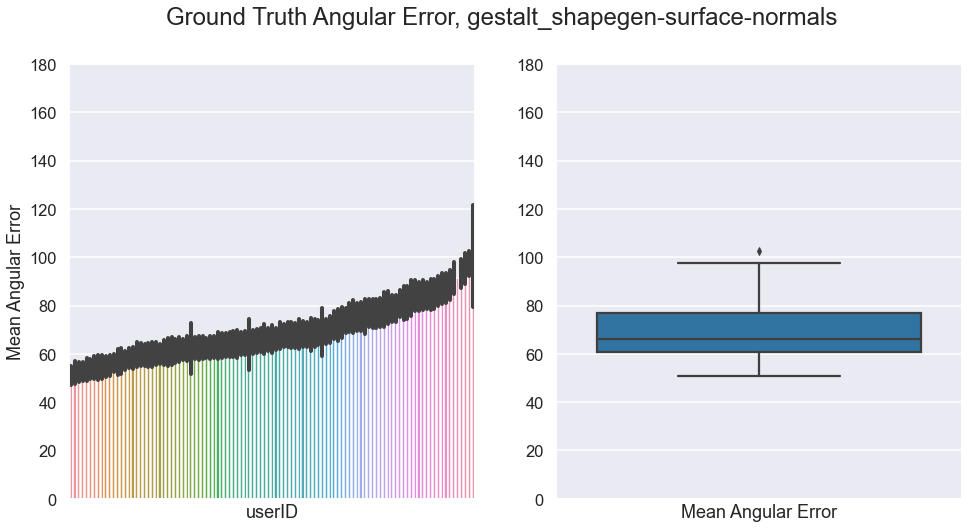

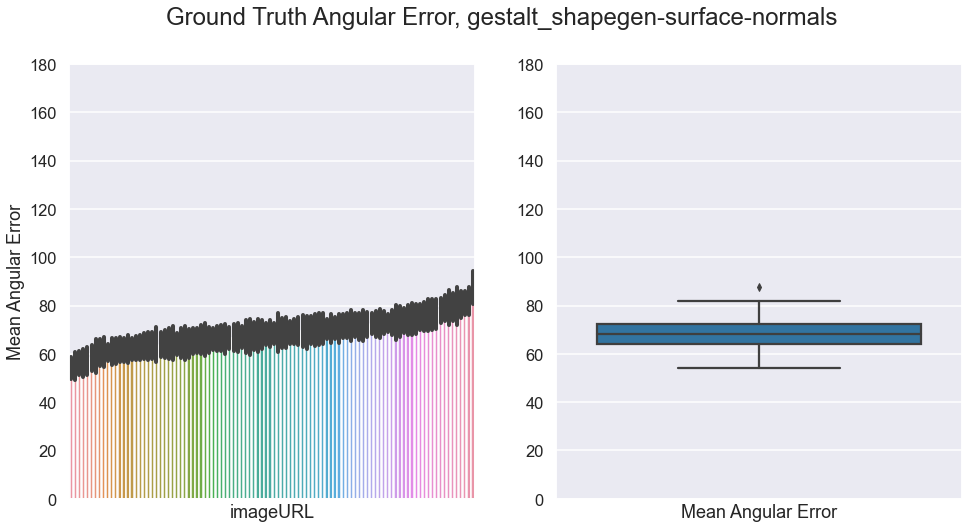

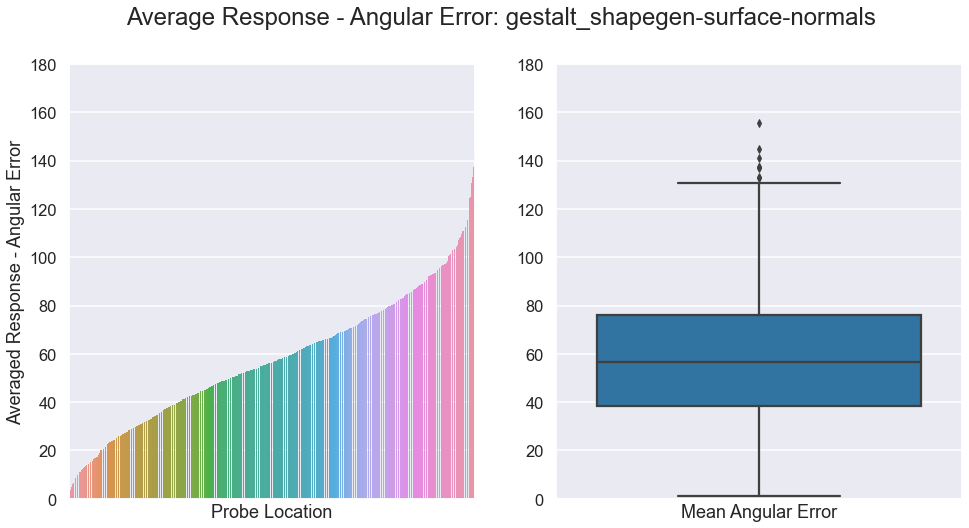

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


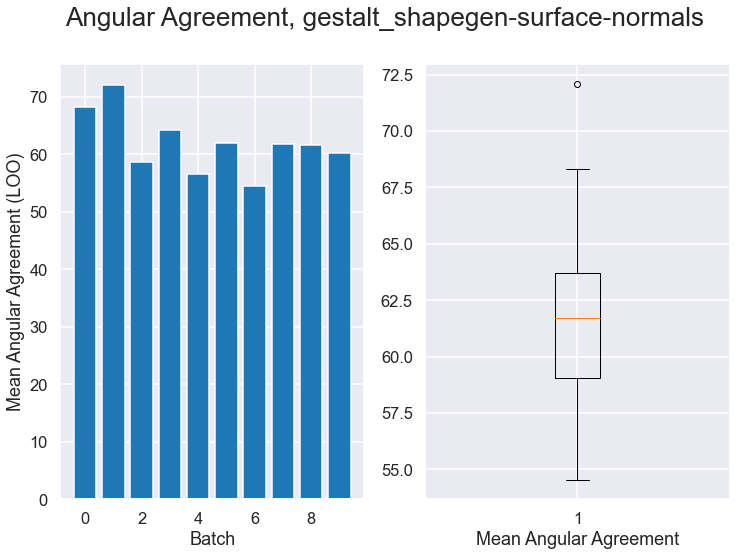

datasets/tdw_surface-normals.csv


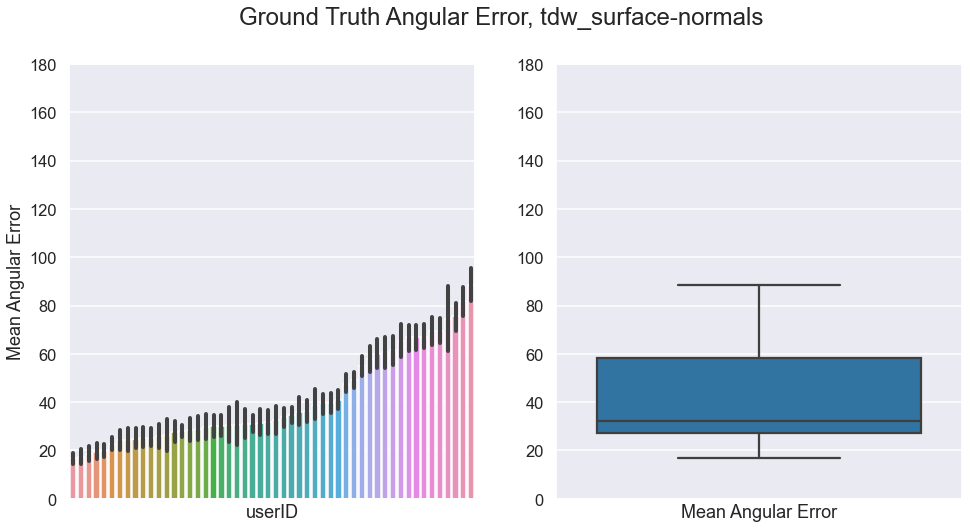

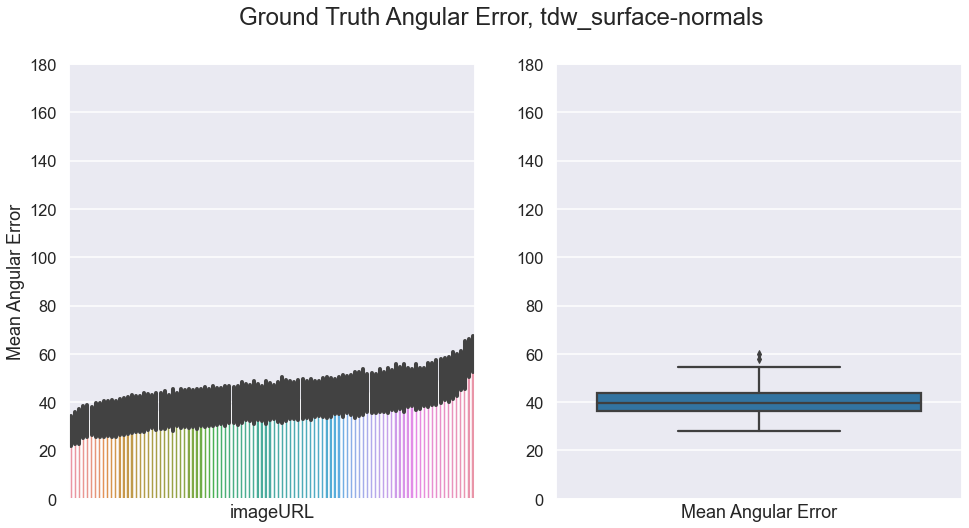

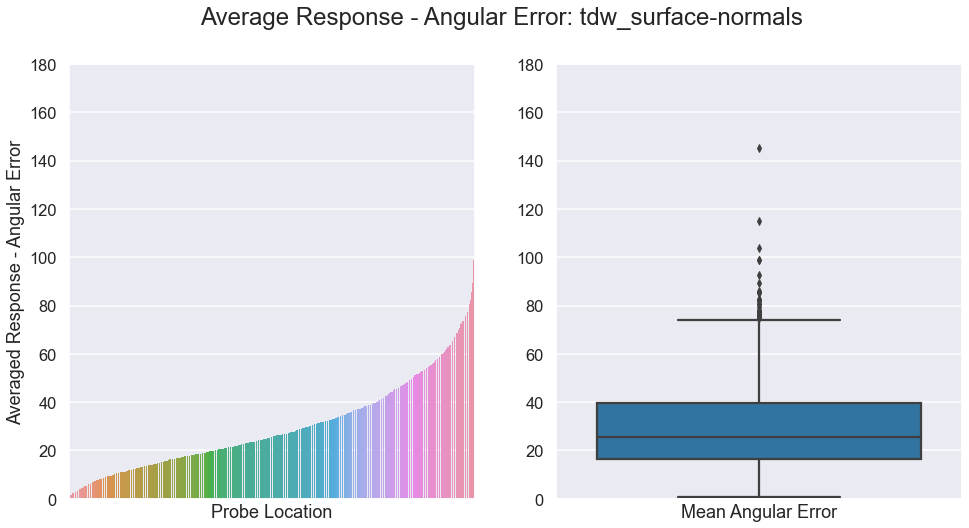

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.31it/s]


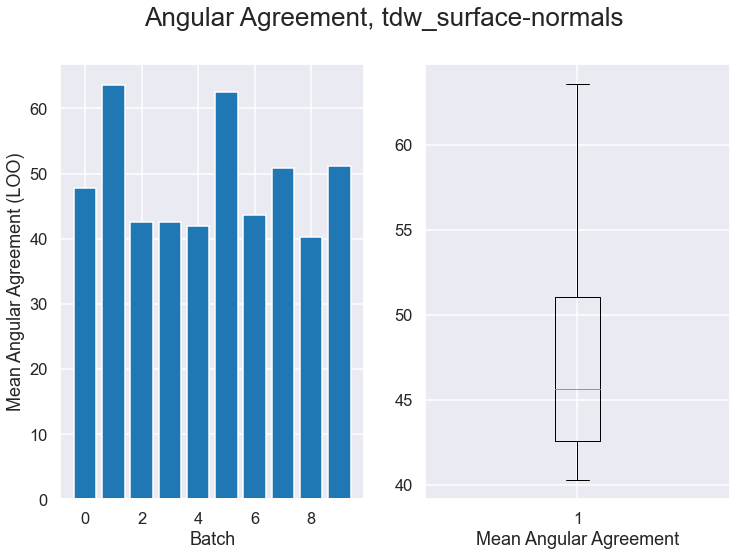

datasets/nsd_surface-normals.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30it/s]


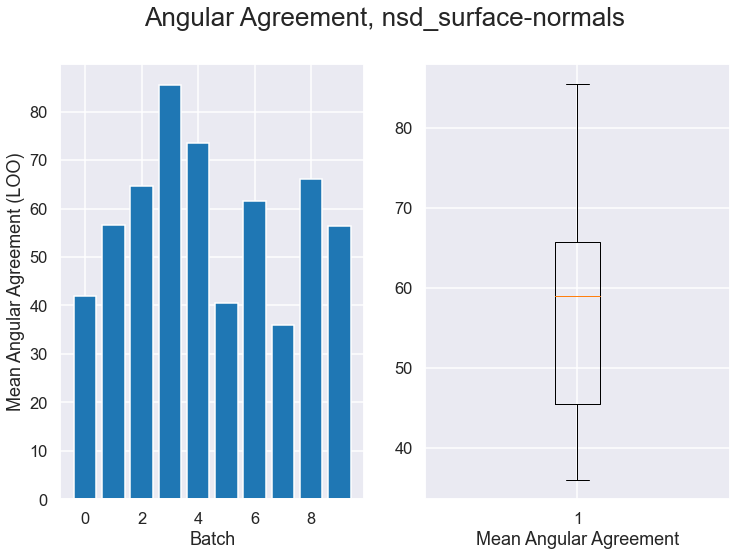

datasets/hypersim_v3-surface-normals.csv


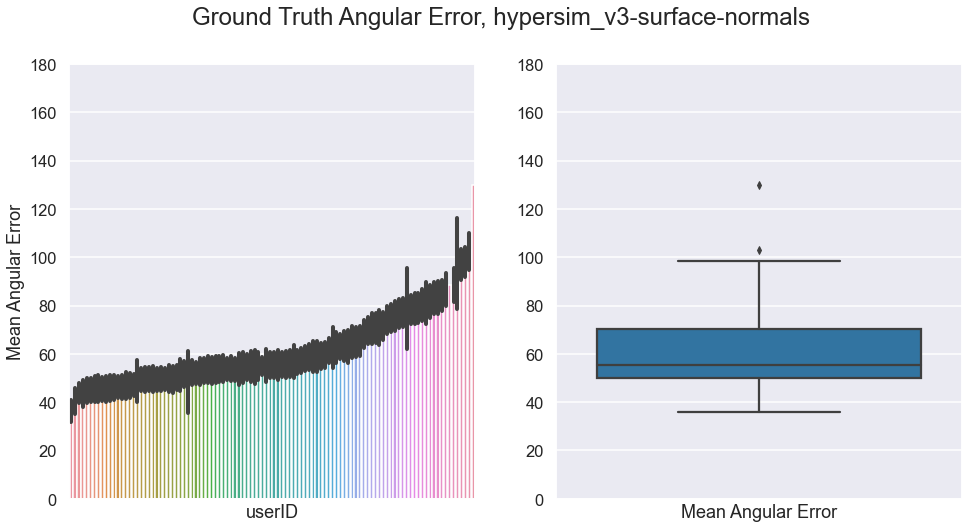

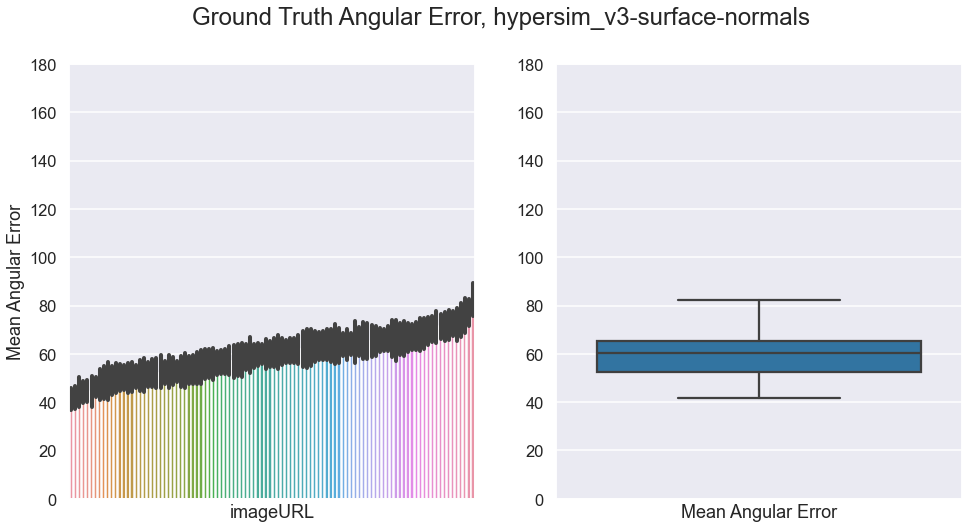

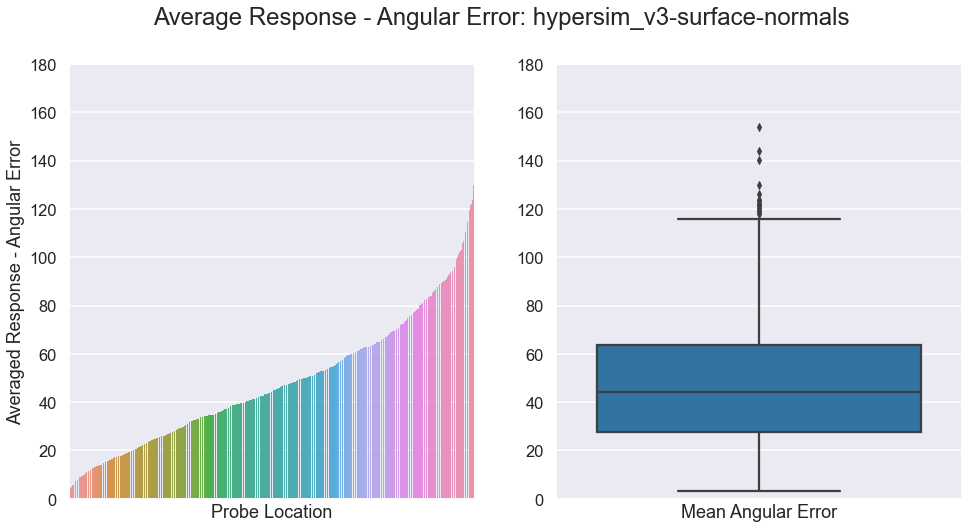

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]


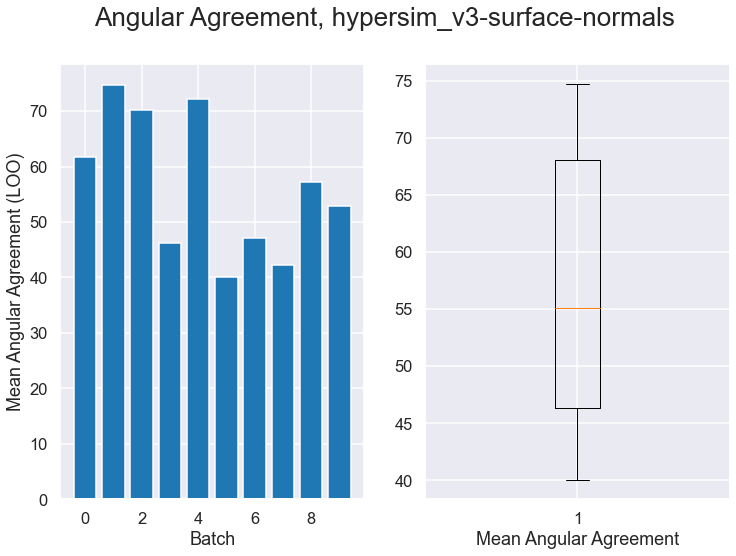

datasets/tdw-surface-normals-split-half.csv


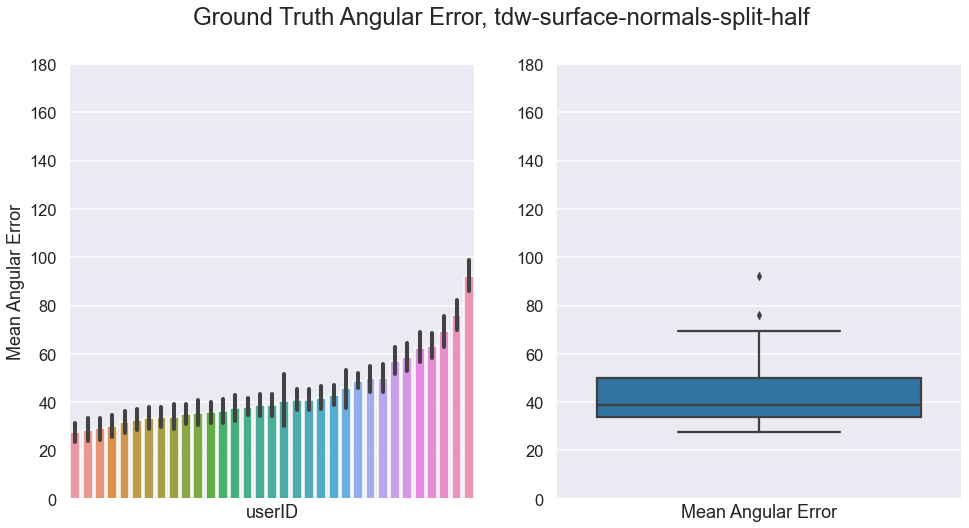

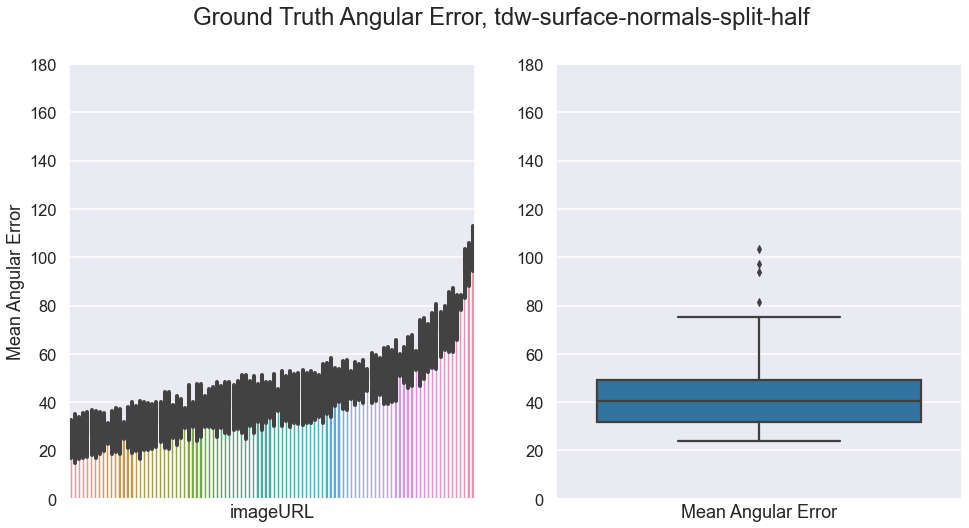

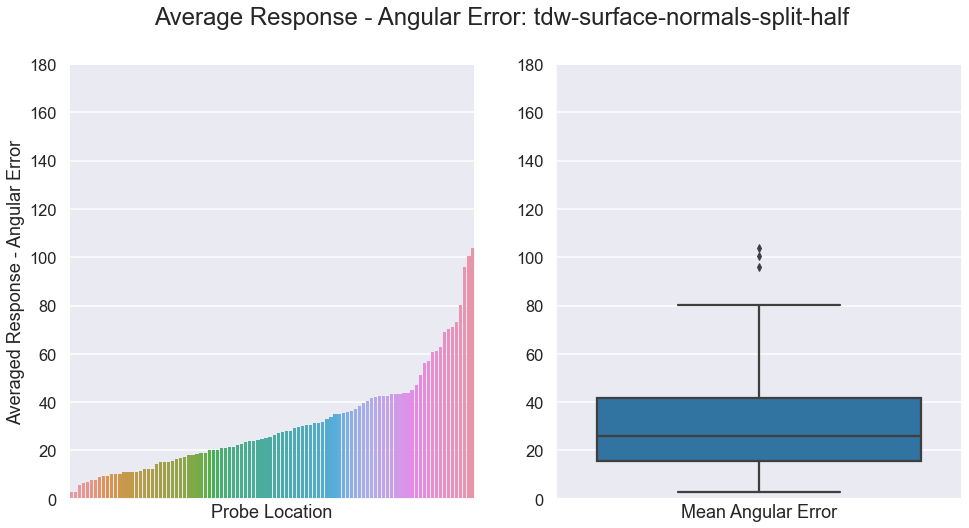

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


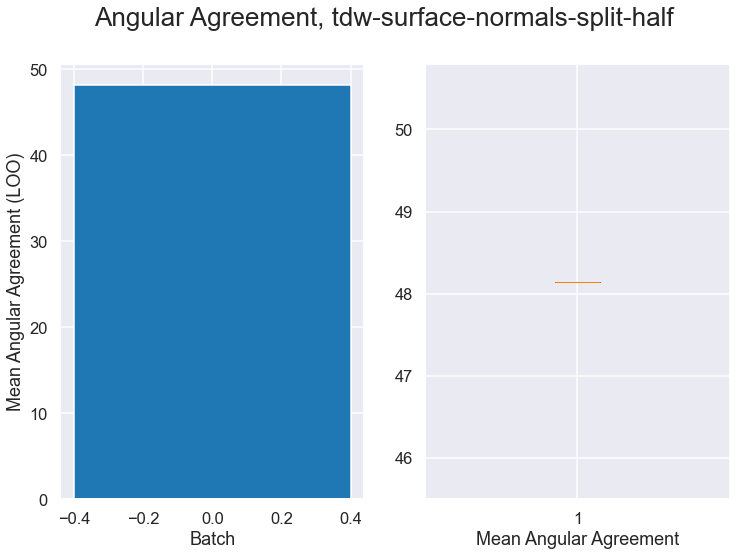

datasets/nsd-surface-normals.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]


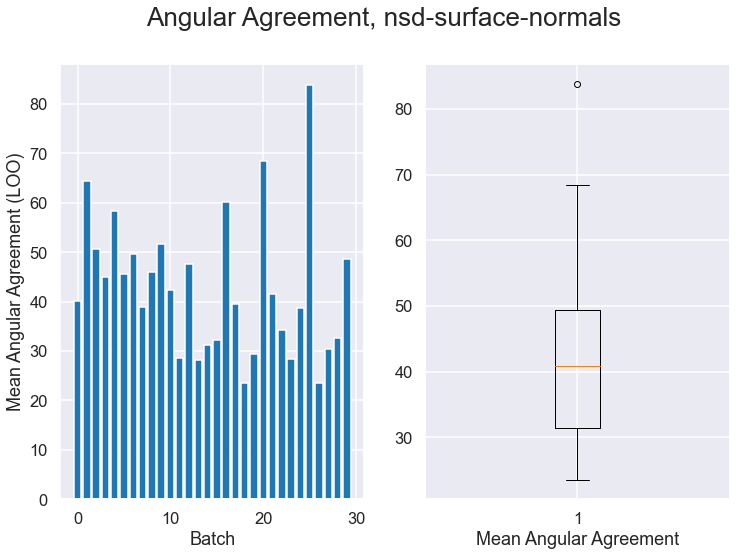

datasets/gestalt_shapegen-surface-normals-split-half.csv


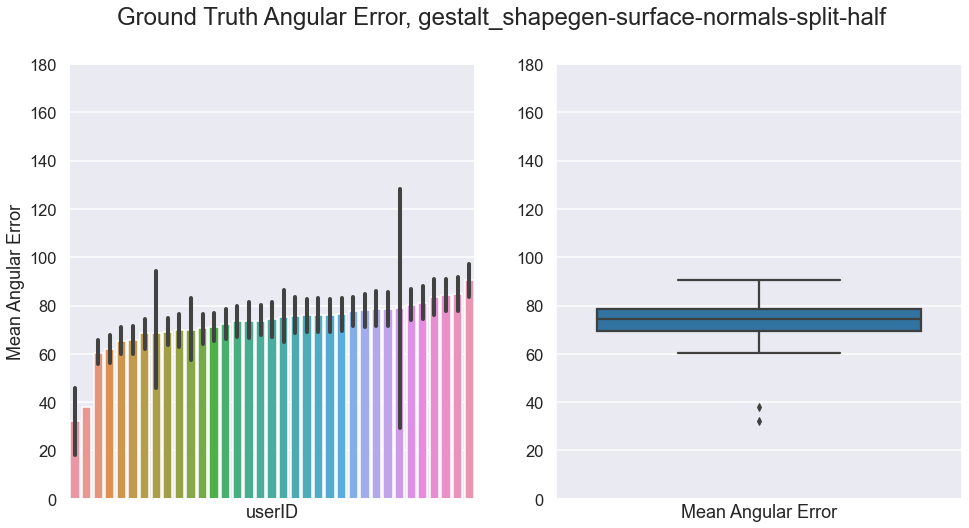

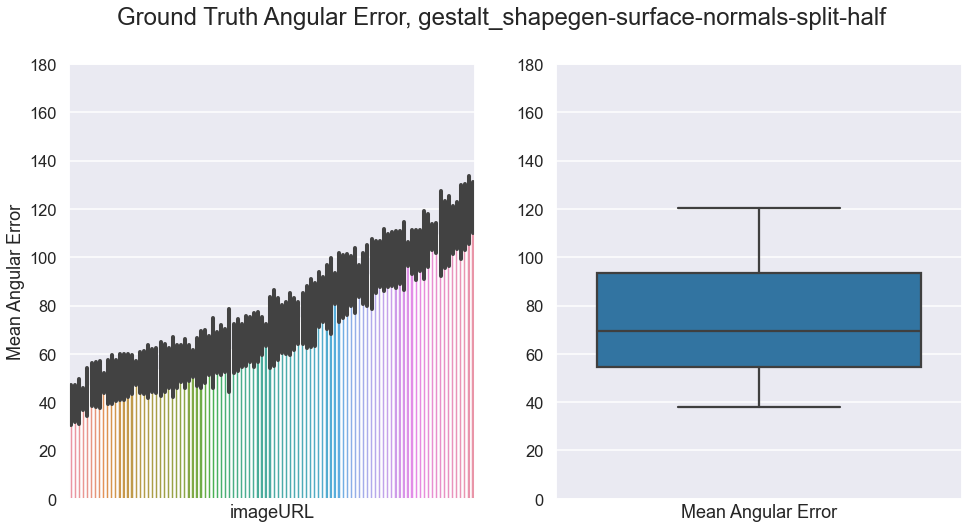

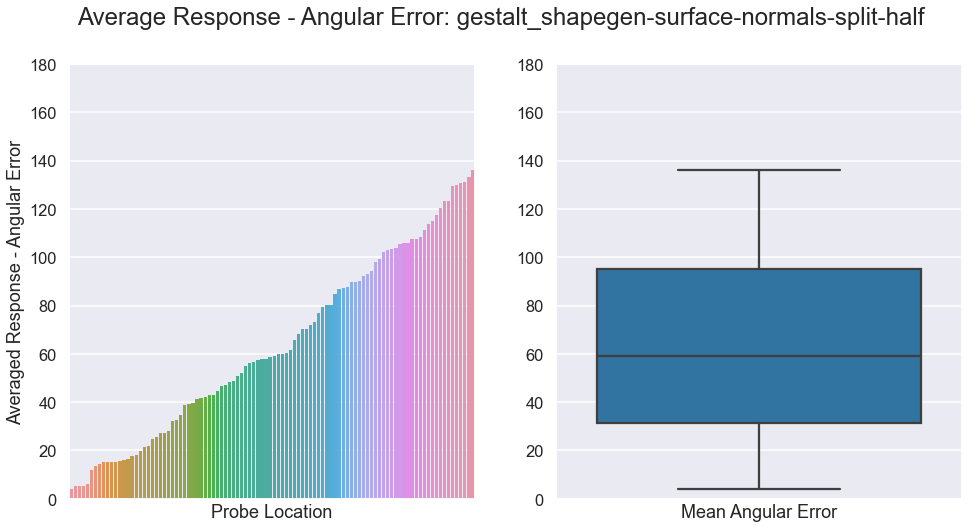

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


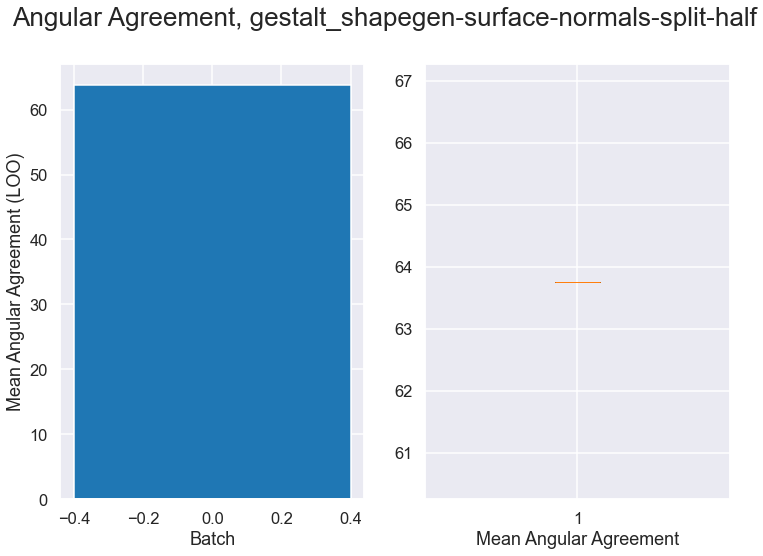

In [117]:
for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "surface-normals" in path:
        if "hypersim_surface-normals" in path:
            continue
        
        print(path)
        
        df = pd.read_csv(path)
        df = df.dropna(axis=0, subset="indicatorFinalDirection")
        get_attention_key = lambda x: [k for k in x if "attention" in k][0]
        attention_key = get_attention_key(df.columns)
        get_duplicate_key = lambda x: [k for k in x if "duplicate" in k][0]
        duplicate_key = get_duplicate_key(df.columns)

        df = df[df[duplicate_key] == False]
        df = df[df[attention_key] == False]
        
        df["indicatorFinalDirection"] = df["indicatorFinalDirection"].apply(str_to_float_array)
        if "nsd" not in col_name:
            df["trueArrowDirection"] = df["trueArrowDirection"].apply(str_to_float_array)
            fig, mean_ae = plotting.plot_mean_angular_error(df, "Ground Truth Angular Error, " + col_name, "userID")
            plt.show()
            plt.close()
            plotting.plot_mean_angular_error(df, "Ground Truth Angular Error, " + col_name, "imageURL")
            plt.show()
            plt.close()
            fig, avg_error = plotting.plot_average_response_angular_error(df, "Average Response - Angular Error: " +col_name)
            plt.show()
            plt.close()
            
        plotting.plot_mean_angular_agreement(df, "Angular Agreement, " + col_name)
        plt.show()
        plt.close()
        if col_name in dsets["normals"]:
            accuracies['normals'][col_name] = mean_ae

In [115]:
accuracies

{'segmentation': {'tdw-segmentation-split-half': 0.9469230769230766,
  'gestalt_shapegen-segmentation-split-half': 0.6958847604008894,
  'tdw-segmentation': 0.8619652406417113,
  'nsd-segmentation': 0.8903382128275836,
  'hypersim_v3-segmentation-split-half': 0.8124184157919233},
 'depth': {'tdw-depth-estimation-pilot': 0.5880567991679103,
  'hypersim_v2-depth-estimation-pilot': 0.6406759142496847,
  'tdw-depth-estimation-split-half': 0.6381766381766382,
  'gestalt_shapegen-depth-estimation-pilot': 0.5060880016722408,
  'hypersim_v3-depth-estimation-split-half': 0.5707692307692308,
  'gestalt_shapegen-depth-estimation-split-half': 0.4489010989010988},
 'normals': {'gestalt_shapegen-surface-normals': 57.88259755168915,
  'hypersim_v3-surface-normals': 48.12336948302645,
  'tdw-surface-normals-split-half': 30.88843488075544,
  'nsd-surface-normals': 30.88843488075544,
  'gestalt_shapegen-surface-normals-split-half': 63.71105781340653}}

In [109]:
split_halfs

{'segmentation': {'tdw-segmentation-split-half': 0.9981785588974833,
  'gestalt_shapegen-segmentation-split-half': 0.9618967049712454,
  'tdw-segmentation': 0.9949695582677536,
  'nsd-segmentation': 0.9890056714243675,
  'hypersim_v3-segmentation-split-half': 0.9917354666888544},
 'depth': {'tdw-depth-estimation-pilot': None,
  'hypersim_v2-depth-estimation-pilot': None,
  'tdw-depth-estimation-split-half': 0.9559864420051212,
  'gestalt_shapegen-depth-estimation-pilot': None,
  'hypersim_v3-depth-estimation-split-half': 0.936997024436114,
  'gestalt_shapegen-depth-estimation-split-half': 0.7879495054701433},
 'normals': {'hypersim_surface-normals': 0.5496765971627458,
  'gestalt_shapegen-surface-normals': 0.6799264978968491,
  'hypersim_v3-surface-normals': 0.4133741149040961,
  'tdw-surface-normals-split-half': 0.8802184702385255,
  'nsd-surface-normals': 0.8659039438943714,
  'hypersim_surface-normals-splithalf': 0.8946280183912695,
  'gestalt_shapegen-surface-normals-split-half': 0

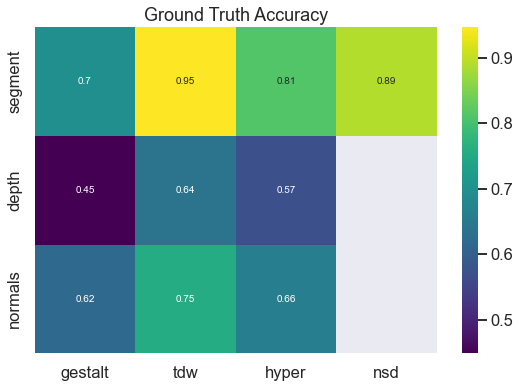

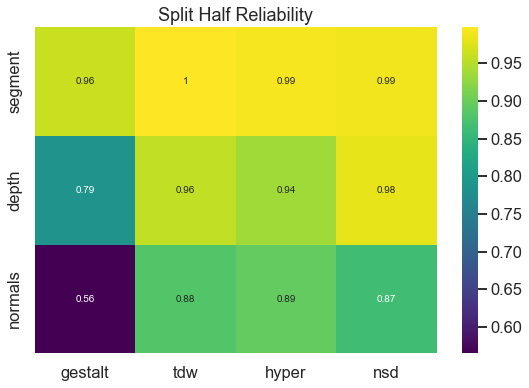

In [118]:
def ae_score(x):
    return 1-(x/180)

dset_keys = ['gestalt', 'tdw', 'hyper', 'nsd']
tasks = ['segment', 'depth', 'normals']

acc_mat = [[accuracies['segmentation']["gestalt_shapegen-segmentation-split-half"], 
            accuracies['segmentation']["tdw-segmentation-split-half"],
            accuracies['segmentation']["hypersim_v3-segmentation-split-half"], 
            accuracies['segmentation']["nsd-segmentation"]],
           
           [accuracies['depth']["gestalt_shapegen-depth-estimation-split-half"], 
            accuracies['depth']["tdw-depth-estimation-split-half"], 
            accuracies['depth']["hypersim_v3-depth-estimation-split-half"], 
            np.nan],
           
           [ae_score(accuracies['normals']["gestalt_shapegen-surface-normals"]), 
            ae_score(accuracies['normals']["tdw-surface-normals-split-half"]), 
            ae_score(accuracies['normals']["hypersim_v3-surface-normals"]), 
            np.nan]]



sh_mat = [[split_halfs['segmentation']["gestalt_shapegen-segmentation-split-half"], 
           split_halfs['segmentation']["tdw-segmentation-split-half"], 
           split_halfs['segmentation']["hypersim_v3-segmentation-split-half"], 
           split_halfs['segmentation']["nsd-segmentation"]],
          
           [split_halfs['depth']["gestalt_shapegen-depth-estimation-split-half"], 
            split_halfs['depth']["tdw-depth-estimation-split-half"], 
            split_halfs['depth']["hypersim_v3-depth-estimation-split-half"], 
            nsd_joint_depth_split_half],
          
           [split_halfs['normals']["gestalt_shapegen-surface-normals-split-half"], 
            split_halfs['normals']["tdw-surface-normals-split-half"], 
            split_halfs['normals']["hypersim_surface-normals-splithalf"], 
            split_halfs['normals']["nsd-surface-normals"]]]

fig = plt.figure(figsize=(9,6))
sns.heatmap(acc_mat, cmap=sns.color_palette("viridis", as_cmap=True), annot=True)
plt.xticks(np.arange(len(dset_keys))+.5, dset_keys)
plt.yticks(np.arange(len(tasks))+.5, tasks)
plt.title("Ground Truth Accuracy")
plt.show()

fig = plt.figure(figsize=(9,6))
sns.heatmap(sh_mat, cmap=sns.color_palette("viridis", as_cmap=True), annot=True)
plt.xticks(np.arange(len(dset_keys))+.5, dset_keys)
plt.yticks(np.arange(len(tasks))+.5, tasks)
plt.title("Split Half Reliability")
plt.show()

([<matplotlib.axis.YTick at 0x2c38d1610>,
 [Text(0, 0.5, 'Response-Averaged'), Text(0, 1.5, 'Mean Accuracy')])

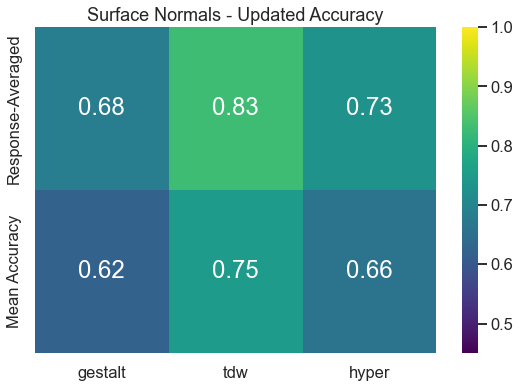

In [139]:
fig = plt.figure(figsize=(9, 6))
results = [[0.68,	0.83,	0.73], [0.62,	0.75,	0.66]]
sns.heatmap(results, vmin=0.45, vmax=1, cmap="viridis", annot=True, annot_kws={"fontsize": 24})
plt.title("Surface Normals - Updated Accuracy")
plt.xticks(np.arange(3)+.5, ["gestalt", "tdw", "hyper"])
plt.yticks(np.arange(2)+.5, ["Response-Averaged", "Mean Accuracy"])